In [1]:
from benchmark_consts import get_problems, get_args_and_problems, print_, PATH_FORM_HYPERPARAMS


import os
import pickle
import traceback
import argparse
import random
import math

import sys
sys.path.append('..')

from lib.algorithms import PathFormulation
from lib.problem import Problem
from lib.graph_utils import compute_in_or_out_flow, path_to_edge_list, assert_flow_conservation
from collections import defaultdict
import ncflow

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

TOP_DIR = 'path-form-logs'
HEADERS = [
    'problem', 'num_nodes', 'num_edges', 'traffic_seed', 'scale_factor',
    'tm_model', 'num_commodities', 'total_demand', 'algo', 'num_paths',
    'edge_disjoint', 'dist_metric', 'total_flow', 'runtime'
]
PLACEHOLDER = ','.join('{}' for _ in HEADERS)


In [2]:
# paths_dict: key: (source, target), value: array of paths,
#             where a path is a list of sequential nodes
#             use lib.graph_utils.path_to_edge_list to get edges.
def split_problem_smartpath(problem, num_subproblems, paths_dict):
    com_list = problem.commodity_list
    
    # create dictionary of all edges used by each commodity
    com_path_edges_dict = defaultdict(list)
    for k, (source, target, demand) in com_list:
        paths_array = paths_dict[(source, target)]
        for path in paths_array:
            com_path_edges_dict[(k, source, target)] += list(path_to_edge_list(path))
        
    # for each edge, split all commodities using that edge across subproblems
    subproblem_com_indices = defaultdict(list)
    current_subproblem = 0
    for (u,v) in problem.G.edges:
        coms_on_edge = [x for x in com_path_edges_dict.keys() if (u,v) in com_path_edges_dict[x]]
        
        # split commodities that share path across all subproblems
        for (k, source, target) in coms_on_edge:
            subproblem_com_indices[current_subproblem] += [(k,source,target)]
            current_subproblem = (current_subproblem + 1) % num_subproblems
            # remove commodity from cosideration when processing later edges
            del com_path_edges_dict[(k, source, target)]
    
    # create subproblems, zero out commodities in traffic matrix that aren't assigned to each 
    sub_problems = []
    for i in range(num_subproblems):
        
        sub_problems.append(problem.copy())
        
        #zero out all commodities not assigned to subproblem i
        for k in subproblem_com_indices.keys():
            if k == i:
                continue
            zero_out_list = subproblem_com_indices[k]
            for ind, source, target in zero_out_list:
                sub_problems[-1].traffic_matrix.tm[source,target] = 0
        
        # split the capacity of each link
        for u,v in sub_problems[-1].G.edges:
            sub_problems[-1].G[u][v]['capacity'] = sub_problems[-1].G[u][v]['capacity']/num_subproblems
    
    return sub_problems
        
#Input: a Problem, and a list of number representing the divisions
def split_problem(problem, num_subproblems):
    sub_problems = []
    num_rows = len(problem.traffic_matrix.tm)
    rows_per_problem = math.floor(num_rows/num_subproblems)
    shuffled_indices = list(range(num_rows))
    
    for i in range(num_subproblems):
        
        sub_problems.append(problem.copy())
        for indx, j in enumerate(shuffled_indices):
            
            # zero out all rows except those in the corresponding block of shuffled indices
            # first, cover special case for last block
            if i == num_subproblems-1:
                if indx < i*rows_per_problem:
                    sub_problems[-1].traffic_matrix.tm[j,:] = 0
            
            elif (indx < i*rows_per_problem) or (indx >= (i+1)*rows_per_problem):
                sub_problems[-1].traffic_matrix.tm[j,:] = 0
            
        # split the capacity of each link
        for u,v in sub_problems[-1].G.edges:
            sub_problems[-1].G[u][v]['capacity'] = sub_problems[-1].G[u][v]['capacity']/num_subproblems

    return sub_problems
        
# Sweep topos and traffic matrices for that topo. For each combo, record the
# runtime and total flow for each algorithm
def benchmark_split(problems, num_subproblems_list, obj, smart=True):
    num_paths, edge_disjoint, dist_metric = PATH_FORM_HYPERPARAMS
    
    if (obj == 'max_flow'):
        pf_original = PathFormulation.new_max_flow(
            num_paths,
            edge_disjoint=edge_disjoint,
            dist_metric=dist_metric)
    elif (obj == 'min_max_link_util'):
        pf_original = PathFormulation.new_min_max_link_util(
            num_paths,
            edge_disjoint=edge_disjoint,
            dist_metric=dist_metric)
    else:
        print(obj + " not supported")
        return
    
    all_results = {}
    all_runtimes = {}
    all_sol_dicts = {}
    with open('path-form.csv', 'a') as results:
        print_(','.join(HEADERS), file=results)
        for problem_name, topo_fname, tm_fname in problems:
            problem = Problem.from_file(topo_fname, tm_fname)
            
            paths_dict = pf_original.get_paths(problem)
            
            problem_results = [[] for _ in range(len(num_subproblems_list))]
            problem_runtimes = [[] for _ in range(len(num_subproblems_list))]
            problem_sol_dicts = [[] for _ in range(len(num_subproblems_list))]
            for nsp_i, num_subproblems in enumerate(num_subproblems_list):
                
                if smart:
                    problem_list = split_problem_smartpath(problem, num_subproblems, paths_dict)
                else:
                    problem_list = split_problem(problem, num_subproblems)
                sum_obj_val = 0
                for sp_i, sub_problem in enumerate(problem_list):

                    print_(sub_problem.name, tm_fname)
                    traffic_seed = sub_problem.traffic_matrix.seed
                    total_demand = sub_problem.total_demand
                    print_('traffic seed: {}'.format(traffic_seed))
                    print_('traffic scale factor: {}'.format(
                        sub_problem.traffic_matrix.scale_factor))
                    print_('traffic matrix model: {}'.format(
                        sub_problem.traffic_matrix.model))
                    print_('total demand: {}'.format(total_demand))

                    run_dir = os.path.join(
                        TOP_DIR, sub_problem.name,
                        '{}-{}'.format(traffic_seed, sub_problem.traffic_matrix.model))
                    if not os.path.exists(run_dir):
                        os.makedirs(run_dir)

                    try:
                        print_(
                            '\nPath formulation, {} paths, edge disjoint {}, dist metric {}'
                            .format(num_paths, edge_disjoint, dist_metric))
                        with open(
                                os.path.join(
                                    run_dir,
                                    '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}.txt'
                                    .format(sub_problem.name, num_paths, edge_disjoint,
                                            dist_metric)), 'w') as log:
                            
                            if (obj == 'max_flow'):
                                pf = PathFormulation.new_max_flow(
                                    num_paths,
                                    edge_disjoint=edge_disjoint,
                                    dist_metric=dist_metric,
                                    out=log)
                            elif (obj == 'min_max_link_util'):
                                pf = PathFormulation.new_min_max_link_util(
                                    num_paths,
                                    edge_disjoint=edge_disjoint,
                                    dist_metric=dist_metric,
                                    out=log)
                            else:
                                print(obj + " not supported")
                                break

                            pf.solve(sub_problem)
                            pf_sol_dict = pf.extract_sol_as_dict()
                            with open(
                                    os.path.join(
                                        run_dir,
                                        '{}-path-formulation_{}-paths_edge-disjoint-{}_dist-metric-{}_sol-dict.pkl'
                                        .format(sub_problem.name, num_paths, edge_disjoint,
                                                dist_metric)), 'wb') as w:
                                pickle.dump(pf_sol_dict, w)

                        result_line = PLACEHOLDER.format(
                            sub_problem.name,
                            len(sub_problem.G.nodes),
                            len(sub_problem.G.edges),
                            traffic_seed,
                            sub_problem.traffic_matrix.scale_factor,
                            sub_problem.traffic_matrix.model,
                            len(problem.commodity_list),
                            total_demand,
                            'path_formulation',
                            num_paths,
                            edge_disjoint,
                            dist_metric,
                            pf.obj_val,
                            pf.runtime,
                        )
                        print_(result_line, file=results)
                        problem_results[nsp_i].append(pf.obj_val)
                        problem_runtimes[nsp_i].append(pf.runtime)
                        problem_sol_dicts[nsp_i].append(pf_sol_dict)
                        sum_obj_val += pf.obj_val
                    except Exception:
                        print_(
                            'Path formulation {} paths, edge disjoint {}, dist metric {}, Problem {}, traffic seed {}, traffic model {} failed'
                            .format(num_paths, edge_disjoint, dist_metric,
                                    sub_problem.name, traffic_seed,
                                    sub_problem.traffic_matrix.model))
                        traceback.print_exc(file=sys.stdout)
                print("sum of obj vals: " + str(sum_obj_val))
               
            all_results[(problem_name, topo_fname, tm_fname)] = problem_results
            all_runtimes[(problem_name, topo_fname, tm_fname)] = problem_runtimes
            all_sol_dicts[(problem_name, topo_fname, tm_fname)] = problem_sol_dicts
    return all_results, all_runtimes, all_sol_dicts

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--dry-run',
                        dest='dry_run',
                        action='store_true',
                        default=False)

parser.add_argument('--slices',
                        type=int,
                        choices=range(5),
                        nargs='+',
                        required=True)
args = parser.parse_args("--slices 0".split())

if not os.path.exists(TOP_DIR):
    os.makedirs(TOP_DIR)

#problems = get_problems(args)

if args.dry_run:
    print('Problems to run:')
    for problem in problems:
        print(problem)

p1 = ("uniform 64", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
p2 = ("poisson-inter 128", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/poisson-high-inter/GtsCe.graphml_poisson_2035531455_128.0_1000.0_0.9_8.5e-05_traffic-matrix.pkl")
p3 = ("poisson-intra 128", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/poisson-high-intra/GtsCe.graphml_poisson_1367969278_128.0_200000000.0_0.1_2.25e-06_traffic-matrix.pkl")
p4 = ("uniform 8", "../topologies/topology-zoo/GtsCe.graphml", 
                        "../traffic-matrices/uniform/GtsCe.graphml_uniform_19019979_8.0_0.05_traffic-matrix.pkl")

p5 = ("kdl_16", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_1710674203_16.0_24000.064453125_True_traffic-matrix.pkl")
p6 = ("kdl_32", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_1836337794_32.0_48001.9765625_True_traffic-matrix.pkl")
p7 = ("kdl_64", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_530572184_64.0_95909.890625_True_traffic-matrix.pkl")
p8 = ("kdl_128", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_378818577_128.0_192067.765625_True_traffic-matrix.pkl")

p9 = ("cogentco_16", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1443251160_16.0_19189.4609375_True_traffic-matrix.pkl")
p10 = ("cogentco_32", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl")
p11 = ("cogentco_64", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1693196370_64.0_76793.84375_True_traffic-matrix.pkl")
p12 = ("cogentco_128", "../topologies/topology-zoo/Cogentco.graphml",
         "../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl")

p13 = ("kdl_8", "../topologies/topology-zoo/Kdl.graphml",
         "../traffic-matrices/gravity/Kdl.graphml_gravity_2139423624_8.0_11990.4140625_True_traffic-matrix.pkl")

num_subproblems = [1,4,8,16,32]
#num_subproblems = [1,2,4,8,16,32,64,81]
#problems = [(os.path.basename(p1[1]), p1[1], p1[2])]
problems = [p10, p12]#,p10,p11]
#problems = [p5,p6,p7,p8,p9,p10,p11,p12]

obj_types = ["max_flow"]#, "min_max_link_util"]
#obj_types = ["min_max_link_util"]

In [4]:
def validate_solution(sol_dicts_all, num_subproblems):
    for obj_type in obj_types:
        sol_dicts = sol_dicts_all[obj_type]
        for p_spec in problems:
            problem = Problem.from_file(p_spec[1], p_spec[2])
            com_list = problem.commodity_list
            
            for n_i, n in enumerate(num_subproblems):
                merged_sol_dict = defaultdict(int)
                for j in range(n):
                    sol_dict = sol_dicts[p_spec][n_i][j]
                    total_flow = 0
                    for commod_key, flow_list in sol_dict.items():
                        assert_flow_conservation(flow_list, commod_key)
                        src, target = commod_key[-1][0], commod_key[-1][1]

                        flow = compute_in_or_out_flow(flow_list, 0, {commod_key[-1][0]})

                        merged_sol_dict[(src,target)] += flow
            
                frac_demands_satisfied = {commod_key:
                                      merged_sol_dict[(commod_key[-1][0],
                                                       commod_key[-1][1])] / commod_key[-1][-1]
                                      for commod_key in com_list}
                for commod_key, frac in frac_demands_satisfied.items():
                    if frac > 1:
                        print("assertion error, demand oversatisfied "+ str(commod_key) + " " + str(frac))
                        break
                    

In [5]:
results_all_obj = {}
runtimes_all_obj = {}
sol_dicts_all_obj = {}
for obj_type in obj_types:
    
    results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems, obj_type, smart=False)
    results_all_obj[obj_type] = results
    runtimes_all_obj[obj_type] = runtimes
    sol_dicts_all_obj[obj_type] = sol_dicts

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Cogentco.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 38612
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 38304.9609375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Academic license - for non-commercial use only
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39096 rows, 66863 columns and 943429 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...



  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 3382 rows and 1785 columns
Presolve time: 0.14s
Presolved: 6662 rows, 14533 columns, 216022 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.057e+05
 Factor NZ  : 2.242e+05 (roughly 10 MBytes of memory)
 Factor Ops : 1.144e+07 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.30 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 3675 iterations and 0.31 seconds
Optimal objective  3.482254096e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 10756.255859375

Path formulation, 4 paths, edge 

   0   4.71055088e+05  3.98072923e+03  6.42e+04 1.76e+00  3.00e+02     0s
   1   9.84516644e+04  2.35790949e+04  1.33e+04 7.26e-01  6.30e+01     0s
   2   1.61228364e+04  2.42897398e+04  1.96e+03 1.37e-01  1.06e+01     0s
   3   3.08543507e+03  1.55821926e+04  2.07e+02 1.25e-02  1.83e+00     0s
   4   1.75996552e+03  5.35025871e+03  2.25e+01 1.02e-03  3.25e-01     0s
   5   1.76567477e+03  3.20511925e+03  5.24e+00 2.80e-04  1.18e-01     0s
   6   1.78429520e+03  2.73814436e+03  4.43e+00 1.61e-04  7.84e-02     0s
   7   1.83280264e+03  2.50135463e+03  2.87e+00 9.42e-05  5.45e-02     0s
   8   1.89521472e+03  2.39829084e+03  1.49e+00 5.75e-05  4.02e-02     0s
   9   1.94225338e+03  2.25352330e+03  7.41e-01 2.90e-05  2.46e-02     0s

Barrier performed 9 iterations in 0.29 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 2688 iterations and 0.29 seconds
Optimal objective  1.992799556e+03
Cogentco.graphml ../traffic-matrices/gravit

   3   2.89716133e+03  4.27868421e+03  1.06e+02 8.65e-03  2.74e-01     0s
   4   2.33280751e+03  3.03729778e+03  2.20e+01 2.96e-03  8.70e-02     0s
   5   2.28942533e+03  2.79366901e+03  1.14e+01 2.09e-03  5.65e-02     0s
   6   2.27509080e+03  2.70241415e+03  7.21e+00 1.78e-03  4.51e-02     0s

Barrier performed 6 iterations in 0.17 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 2415 iterations and 0.18 seconds
Optimal objective  2.246820475e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 5796.310546875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 6137 rows, 


Barrier performed 0 iterations in 0.05 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 310 iterations and 0.06 seconds
Optimal objective  6.128312814e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 2294.5703125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2775 rows, 4387 columns and 70357 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve r


                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.43322784e+05  1.16101601e+03  2.80e+04 5.58e-01  1.32e+02     0s
   1   2.38573851e+04  7.17946530e+03  4.60e+03 5.89e-01  2.26e+01     0s

Barrier performed 1 iterations in 0.14 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 673 iterations and 0.14 seconds
Optimal objective  5.577072715e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1904.970947265625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2770 rows, 4284 columns and 77

traffic matrix model: gravity
total demand: 2350.8798828125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2785 rows, 4059 columns and 58434 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 953 rows and 363 columns
Presolve time: 0.04s
Presolved: 1832 rows, 3696 columns, 49295 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.492e+04
 Factor NZ  : 6.992e+04 (roughly 3 MBytes of memory)
 Factor Ops : 5.209e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual     


Barrier performed 0 iterations in 0.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 115 iterations and 0.07 seconds
Optimal objective  1.984703367e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1097.119873046875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1543 rows, 1826 columns and 25798 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Preso

 Factor Ops : 2.787e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.06 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 89 iterations and 0.06 seconds
Optimal objective  1.246823224e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1357.651611328125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1584 rows, 2277 columns and 33620 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 3e+01]

Concurrent LP optimizer: p

traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1104.699951171875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1590 rows, 2187 columns and 30651 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 430 rows and 96 columns
Presolve time: 0.03s
Presolved: 1160 rows, 2091 columns, 26551 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.086e+04
 Factor NZ  : 4.231e+04 (roughly 2 MBytes of memory)
 Factor Ops : 2.416e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0


Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 624 rows and 175 columns
Presolve time: 0.04s
Presolved: 964 rows, 1941 columns, 21687 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.281e+04
 Factor NZ  : 3.352e+04 (roughly 1 MByte of memory)
 Factor Ops : 1.791e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.05 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 128 iterations and 0.06 seconds
Optimal objective  2.358229466e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1105.471923828125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Defa


Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.363e+04
 Factor NZ  : 3.314e+04 (roughly 1 MByte of memory)
 Factor Ops : 1.637e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.07 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 236 iterations and 0.07 seconds
Optimal objective  3.248092449e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1248.686279296875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1604 rows, 2032 columns and 32077 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objecti


Barrier solved model in 28 iterations and 5.16 seconds
Optimal objective 5.02899977e+04

Crossover log...

     197 DPushes remaining with DInf 0.0000000e+00                 5s
       0 DPushes remaining with DInf 0.0000000e+00                 5s

   11505 PPushes remaining with PInf 0.0000000e+00                 5s

Solved with dual simplex
Solved in 30692 iterations and 5.49 seconds
Optimal objective  5.028999781e+04
sum of obj vals: 50289.997813437134
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 38930.95703125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10051 rows, 16401 columns and 225134 nonzeros
Coefficient stat

   6   9.97927308e+03  1.82197592e+04  4.63e+01 9.69e-04  4.96e-01     0s
   7   9.89505557e+03  1.56161660e+04  2.86e+01 5.64e-04  3.15e-01     0s
   8   1.00739905e+04  1.39723536e+04  2.10e+01 3.17e-04  2.12e-01     0s
   9   1.02909298e+04  1.28989739e+04  1.55e+01 1.68e-04  1.42e-01     0s
  10   1.04156549e+04  1.24422420e+04  1.22e+01 9.17e-05  1.11e-01     1s
  11   1.06285329e+04  1.21506866e+04  8.22e+00 5.21e-05  8.13e-02     1s
  12   1.07142223e+04  1.19209847e+04  6.93e+00 3.99e-05  6.50e-02     1s
  13   1.08331473e+04  1.17851768e+04  5.35e+00 2.17e-05  5.07e-02     1s
  14   1.09239560e+04  1.16628495e+04  4.27e+00 1.27e-05  3.95e-02     1s

Barrier performed 14 iterations in 0.59 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 6561 iterations and 0.60 seconds
Optimal objective  1.133117892e+04
sum of obj vals: 34807.404266133904
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_1

Optimize a model with 5130 rows, 8615 columns and 148941 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 924 rows and 241 columns
Presolve time: 0.06s
Presolved: 4206 rows, 8374 columns, 142965 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.519e+05
 Factor NZ  : 1.773e+05 (roughly 7 MBytes of memory)
 Factor Ops : 1.203e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.13983792e+05  7.21723741e+03  6.13e+04 1.95e+00  4.71e+02     0s
   1   1.79747600e+05  7.35053963e+04  1.54e+04 9.05e-01  1.21e+02     0s
   2   3.21446843e+04  7.38540430e+04  2.57e+03 2.86e-01  2.47e+01     0s
   3   7.17582622

traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 9438.515625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2771 rows, 4257 columns and 62188 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 676 rows and 140 columns
Presolve time: 0.05s
Presolved: 2095 rows, 4117 columns, 58896 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.625e+04
 Factor NZ  : 9.262e+04 (roughly 3 MBytes of memory)
 Factor Ops : 6.100e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective            


Barrier performed 2 iterations in 0.10 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 157 iterations and 0.10 seconds
Optimal objective  1.010337407e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 7905.068359375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2773 rows, 3687 columns and 45864 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presol

Presolved: 1969 rows, 4189 columns, 48764 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.471e+04
 Factor NZ  : 8.330e+04 (roughly 3 MBytes of memory)
 Factor Ops : 5.646e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.01504941e+05  5.03123368e+03  3.35e+04 1.12e+00  2.40e+02     0s
   1   6.05697833e+04  2.99613834e+04  6.64e+03 6.82e-01  5.03e+01     0s

Barrier performed 1 iterations in 0.08 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 247 iterations and 0.08 seconds
Optimal objective  1.277248609e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 10662.4384765625

Path formulation, 4 pa

Showing barrier log only...

Presolve removed 470 rows and 72 columns
Presolve time: 0.03s
Presolved: 1115 rows, 1997 columns, 26837 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.103e+04
 Factor NZ  : 5.280e+04 (roughly 2 MBytes of memory)
 Factor Ops : 2.907e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.06 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 73 iterations and 0.07 seconds
Optimal objective  2.796173691e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 4439.26953125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  De

Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 59 iterations and 0.04 seconds
Optimal objective  3.851015028e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 4138.94970703125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1541 rows, 2145 columns and 35719 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 316 rows and 60 columns
Presolve tim

traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 3808.082763671875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1587 rows, 1865 columns and 22262 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 679 rows and 114 columns
Presolve time: 0.02s
Presolved: 908 rows, 1751 columns, 19958 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.144e+04
 Factor NZ  : 3.947e+04 (roughly 1 MByte of memory)
 Factor Ops : 1.970e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0

total demand: 4462.0439453125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1594 rows, 2028 columns and 32077 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 470 rows and 81 columns
Presolve time: 0.04s
Presolved: 1124 rows, 1947 columns, 30029 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.596e+04
 Factor NZ  : 6.084e+04 (roughly 2 MBytes of memory)
 Factor Ops : 4.154e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.06 seconds
Barrier solve interrupted - model solved by another algorithm


Solved w

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 4e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 264 rows and 56 columns
Presolve time: 0.02s
Presolved: 1328 rows, 2228 columns, 26890 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.448e+04
 Factor NZ  : 6.053e+04 (roughly 2 MBytes of memory)
 Factor Ops : 3.580e+06 (less than 1 second per iteration)
 Threads    : 26

Barrier performed 0 iterations in 0.04 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 70 iterations and 0.04 seconds
Optimal objective  4.753981759e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 4394.7373046875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Chang

In [6]:
results_all_obj_smart = {}
runtimes_all_obj_smart = {}
sol_dicts_all_obj_smart = {}
for obj_type in obj_types:
    
    results, runtimes, sol_dicts = benchmark_split(problems, num_subproblems, obj_type, smart=True)
    results_all_obj_smart[obj_type] = results
    runtimes_all_obj_smart[obj_type] = runtimes
    sol_dicts_all_obj_smart[obj_type] = sol_dicts

Loading paths from pickle file /lfs/1/fiodar/ncflow/topologies/paths/path-form/Cogentco.graphml-4-paths_edge-disjoint-True_dist-metric-inv-cap-dict.pkl
paths_dict size: 38612
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 38304.9609375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39096 rows, 66863 columns and 943429 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 13092 rows and 9086 columns
Pr

   5   6.07907540e+03  6.54090406e+03  1.02e+01 1.17e-03  2.78e-02     0s
   6   6.14069820e+03  6.41913551e+03  5.87e+00 5.25e-04  1.65e-02     0s
   7   6.17404595e+03  6.34418971e+03  3.99e+00 2.77e-04  1.03e-02     1s
   8   6.19695276e+03  6.31180877e+03  2.77e+00 1.73e-04  6.98e-03     1s
   9   6.22049472e+03  6.29263100e+03  1.57e+00 1.16e-04  4.27e-03     1s
  10   6.22748864e+03  6.27902725e+03  1.16e+00 7.87e-05  3.07e-03     1s
  11   6.23108224e+03  6.26525706e+03  9.42e-01 4.37e-05  2.15e-03     1s
  12   6.23467873e+03  6.26261221e+03  7.04e-01 3.72e-05  1.71e-03     1s

Barrier performed 12 iterations in 0.64 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 8843 iterations and 0.65 seconds
Optimal objective  6.243323284e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix m

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.03972011e+05  2.07513958e+03  2.59e+04 1.00e+00  4.87e+01     0s
   1   2.53449541e+04  7.84217306e+03  1.96e+03 1.67e-01  4.26e+00     0s
   2   5.33067962e+03  6.94305069e+03  2.41e+02 4.45e-02  8.01e-01     0s
   3   3.02665093e+03  4.31830458e+03  3.01e+01 4.52e-03  1.67e-01     0s
   4   2.97895780e+03  3.42417613e+03  6.67e+00 1.24e-03  4.71e-02     0s
   5   3.03870774e+03  3.26439282e+03  3.35e+00 3.89e-04  2.36e-02     0s
   6   3.08201564e+03  3.20508321e+03  1.69e+00 2.00e-04  1.26e-02     0s
   7   3.09703096e+03  3.17820814e+03  1.18e+00 1.18e-04  8.40e-03     0s
   8   3.10474751e+03  3.17199976e+03  9.35e-01 9.86e-05  6.90e-03     0s
   9   3.11201574e+03  3.15771502e+03  7.01e-01 5.77e-05  4.78e-03     0s
  10   3.11852159e+03  3.14750829e+03  4.89e-01 3.04e-05  3.09e-03     0s
  11   3.12253623e+03  3.14429370e+03  3.55e-01 2.24e-05  2.30e-03     0s
  12   3.12732580e+03  3.14023331e+03 

   1   2.18577360e+04  7.20657690e+03  2.42e+03 2.83e-01  3.88e+00     0s
   2   5.38932993e+03  6.64744312e+03  3.65e+02 7.38e-02  8.40e-01     0s
   3   3.07538341e+03  4.45865708e+03  4.82e+01 5.37e-03  1.81e-01     0s
   4   3.01872112e+03  3.39332740e+03  1.62e+01 8.52e-04  4.73e-02     0s
   5   3.05725342e+03  3.26569926e+03  8.68e+00 3.85e-04  2.56e-02     0s
   6   3.08637776e+03  3.22153876e+03  5.08e+00 2.37e-04  1.60e-02     0s
   7   3.10495820e+03  3.18096338e+03  2.94e+00 1.21e-04  9.01e-03     0s
   8   3.11288410e+03  3.17027785e+03  2.09e+00 9.14e-05  6.67e-03     0s
   9   3.12036331e+03  3.14886569e+03  1.25e+00 3.39e-05  3.49e-03     0s
  10   3.12575195e+03  3.14037510e+03  6.80e-01 1.47e-05  1.83e-03     0s
  11   3.13000510e+03  3.13726539e+03  2.44e-01 8.22e-06  8.20e-04     0s
  12   3.13068806e+03  3.13676894e+03  1.78e-01 7.13e-06  6.63e-04     0s
  13   3.13088478e+03  3.13409600e+03  1.60e-01 2.36e-06  4.10e-04     0s
  14   3.13177951e+03  3.13199441e+03 

   3   3.00631049e+03  4.42575668e+03  3.43e+01 6.68e-03  1.87e-01     0s
   4   2.95280890e+03  3.56054473e+03  7.40e+00 2.69e-03  6.28e-02     0s
   5   3.01200736e+03  3.27651420e+03  2.27e+00 9.81e-04  2.56e-02     0s
   6   3.04256189e+03  3.18489438e+03  1.06e+00 4.95e-04  1.35e-02     0s
   7   3.05725423e+03  3.13904697e+03  5.49e-01 2.74e-04  7.63e-03     0s
   8   3.06455530e+03  3.11295328e+03  3.14e-01 1.52e-04  4.49e-03     0s
   9   3.07013346e+03  3.10264748e+03  1.57e-01 1.07e-04  2.95e-03     0s
  10   3.07287851e+03  3.09103425e+03  7.82e-02 5.90e-05  1.63e-03     0s
  11   3.07396800e+03  3.08106063e+03  3.27e-02 1.95e-05  6.38e-04     0s
  12   3.07495564e+03  3.07763408e+03  6.27e-03 7.62e-06  2.33e-04     0s
  13   3.07524736e+03  3.07532856e+03  1.78e-15 1.78e-15  6.54e-06     0s
  14   3.07528305e+03  3.07528307e+03  1.78e-15 2.66e-15  2.03e-09     0s

Barrier solved model in 14 iterations and 0.37 seconds
Optimal objective 3.07528305e+03

Crossover log...

    

traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 2414.3330078125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2898 rows, 4184 columns and 58837 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1019 rows and 188 columns
Presolve time: 0.04s
Presolved: 1879 rows, 3996 columns, 49882 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.404e+04
 Factor NZ  : 7.940e+04 (roughly 3 MBytes of memory)
 Factor Ops : 8.142e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective        

   3   1.39393205e+03  2.09714031e+03  4.79e+00 1.82e-03  1.22e-01     0s
   4   1.47351534e+03  1.73972260e+03  7.69e-01 4.49e-04  4.29e-02     0s
   5   1.49193297e+03  1.63893178e+03  5.83e-01 1.75e-04  2.39e-02     0s
   6   1.51735673e+03  1.60236592e+03  3.59e-01 7.79e-05  1.38e-02     0s
   7   1.53683677e+03  1.58400486e+03  2.05e-01 3.43e-05  7.65e-03     0s
   8   1.54901860e+03  1.57403224e+03  1.13e-01 1.31e-05  4.06e-03     0s
   9   1.55368772e+03  1.57117041e+03  7.38e-02 8.68e-06  2.83e-03     0s
  10   1.55872945e+03  1.57083085e+03  3.86e-02 7.83e-06  1.94e-03     0s
  11   1.56024349e+03  1.56827135e+03  2.72e-02 4.09e-06  1.29e-03     0s
  12   1.56292362e+03  1.56593571e+03  8.14e-03 1.25e-06  4.80e-04     0s
  13   1.56327422e+03  1.56490846e+03  5.71e-03 3.00e-07  2.62e-04     0s
  14   1.56365627e+03  1.56441275e+03  2.98e-03 2.51e-08  1.22e-04     0s

Barrier performed 14 iterations in 0.22 seconds
Barrier solve interrupted - model solved by another algorithm




Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2899 rows, 4184 columns and 59453 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1005 rows and 172 columns
Presolve time: 0.04s
Presolved: 1894 rows, 4012 columns, 50552 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.550e+04
 Factor NZ  : 8.055e+04 (roughly 3 MBytes of memory)
 Factor Ops : 8.259e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.01552177e+05

   0   1.00397960e+05  2.41012382e+03  1.26e+04 6.50e-01  4.64e+01     0s
   1   8.03825463e+03  5.01896790e+03  8.31e+02 2.61e-01  3.80e+00     0s
   2   1.91598528e+03  3.71893012e+03  8.40e+01 4.03e-02  6.55e-01     0s
   3   1.40572591e+03  1.91785305e+03  5.06e+00 3.15e-03  9.35e-02     0s
   4   1.47810495e+03  1.68570385e+03  1.78e+00 9.39e-04  3.64e-02     0s
   5   1.50819802e+03  1.63005449e+03  9.97e-01 4.70e-04  2.11e-02     0s
   6   1.52479541e+03  1.59685294e+03  6.27e-01 2.53e-04  1.25e-02     0s
   7   1.53409227e+03  1.58038730e+03  4.28e-01 1.46e-04  8.05e-03     0s

Barrier performed 7 iterations in 0.17 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1736 iterations and 0.18 seconds
Optimal objective  1.554023937e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix mo

   Prev: gurobi.log  Default: 
Optimize a model with 1691 rows, 2086 columns and 28567 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 631 rows and 76 columns
Presolve time: 0.03s
Presolved: 1060 rows, 2010 columns, 23974 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.777e+04
 Factor NZ  : 5.504e+04 (roughly 2 MBytes of memory)
 Factor Ops : 6.829e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.43847722e+04  1.22007562e+03  4.38e+03 6.37e-01  3.19e+01     0s
   1   3.10460854e+03  2.55916552e+03  3.21e+02 1.60e-01  2.98e+00     0s
   2   1.05318232e+03  1.80128728e+03  5.71e+01 1.45e-02  6.31e

   4   7.55387292e+02  8.39094742e+02  1.51e+00 6.66e-16  2.95e-02     0s

Barrier performed 4 iterations in 0.11 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1171 iterations and 0.12 seconds
Optimal objective  7.868142931e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1239.3741455078125

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1691 rows, 2106 columns and 29481 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 3e+01]

Concurrent LP optimizer: pr

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 584 rows and 52 columns
Presolve time: 0.03s
Presolved: 1107 rows, 2056 columns, 26147 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.268e+04
 Factor NZ  : 6.017e+04 (roughly 2 MBytes of memory)
 Factor Ops : 7.679e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.26476860e+04  1.14968345e+03  4.07e+03 6.18e-01  2.55e+01     0s
   1   2.76961267e+03  2.22616972e+03  2.61e+02 1.87e-01  2.21e+00     0s
   2   8.46114474e+02  1.51285362e+03  2.93e+01 1.87e-02  3.93e-01     0s
   3   7.02083140e+02  8.69359169e+02  2.23e+00 8.42e-04  5.77e-02     0s
   4   7.30489663e+02  8.00478112e+02  8.18e-01 1.64e-04  2.33e-02   

traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1153.841796875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1689 rows, 2076 columns and 29906 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 638 rows and 71 columns
Presolve time: 0.04s
Presolved: 1051 rows, 2005 columns, 25369 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.022e+04
 Factor NZ  : 5.645e+04 (roughly 2 MBytes of memory)
 Factor Ops : 6.926e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective           

 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.01965028e+04  1.20454932e+03  3.83e+03 8.08e-01  2.75e+01     0s
   1   3.63320601e+03  2.42126615e+03  3.72e+02 1.54e-01  3.13e+00     0s
   2   9.55041215e+02  1.68472528e+03  4.35e+01 1.11e-02  5.23e-01     0s
   3   6.84281633e+02  8.82237909e+02  2.40e+00 8.88e-16  6.79e-02     0s
   4   7.15582744e+02  8.00159132e+02  1.07e+00 4.44e-16  2.86e-02     0s
   5   7.30923204e+02  7.77124548e+02  6.36e-01 4.44e-16  1.57e-02     0s

Barrier performed 5 iterations in 0.12 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1457 iterations and 0.13 seconds
Optimal objective  7.581060678e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model:

Showing barrier log only...

Presolve removed 642 rows and 71 columns
Presolve time: 0.02s
Presolved: 1048 rows, 1990 columns, 24967 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.010e+04
 Factor NZ  : 5.654e+04 (roughly 2 MBytes of memory)
 Factor Ops : 7.053e+06 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.15619643e+04  1.15720960e+03  3.88e+03 6.09e-01  2.69e+01     0s
   1   2.56902548e+03  2.15139379e+03  2.43e+02 2.71e-01  2.40e+00     0s
   2   7.96603629e+02  1.50446750e+03  2.76e+01 2.74e-02  4.28e-01     0s

Barrier performed 2 iterations in 0.10 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1145 iterations and 0.11 seconds
Optimal objective  7.477126941e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.960937



Solved with dual simplex
Solved in 1198 iterations and 0.12 seconds
Optimal objective  7.617796494e+02
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic scale factor: 32.0
traffic matrix model: gravity
total demand: 1199.02587890625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1690 rows, 2094 columns and 29378 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 609 rows and 60 columns
Presolve time: 0.03s
Presolved: 1081 rows, 2034 columns, 25037 nonzeros

Ord

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+03]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 12588 rows and 4749 columns
Presolve time: 0.34s
Presolved: 26508 rows, 62113 columns, 863452 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.943e+05
 Factor NZ  : 8.413e+05 (roughly 45 MBytes of memory)
 Factor Ops : 5.009e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.30602770e+07  5.09331422e+04  4.17e+05 1.00e+00  5.55e+02     1s
   1   5.85583056e+05  4.18536798e+05  1.76e+04 7.23e-01  2.87e+01     2s
   2   2.21844927e+05  3.77692398e+05  6.04e+03 2.54e-01  1.12e+01     2s
   3   1.23092915e+05  2.12532652e+05  2.78e+03 8.00e-02  4.68e+00     2s
   4   6.87541324e+04  1.11322314e+05  9.78e+02 1.98e-02  1.54e+00     2s
   5   5.53882034e+04

       0 PPushes remaining with PInf 0.0000000e+00                 1s

  Push phase complete: Pinf 0.0000000e+00, Dinf 0.0000000e+00      1s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    5922    1.2417982e+04   0.000000e+00   0.000000e+00      1s

Solved with barrier
Solved in 5922 iterations and 0.74 seconds
Optimal objective  1.241798167e+04
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 38182.27734375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 10138 rows, 16733 columns and 236267 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range 

       0 PPushes remaining with PInf 0.0000000e+00                 0s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2545520e-14      0s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1597    6.1884551e+03   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 1597 iterations and 0.39 seconds
Optimal objective  6.188455090e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 19090.74609375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5313 rows, 8361 columns and 118014 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range   

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5311 rows, 8364 columns and 118139 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 1626 rows and 85 columns
Presolve time: 0.05s
Presolved: 3685 rows, 8279 columns, 114189 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.442e+05
 Factor NZ  : 1.842e+05 (roughly 7 MBytes of memory)
 Factor Ops : 2.830e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.34585597e+05  6.60789612e+03  2.65e+04 1.00e+00  6.44e+01     0s
   1   4.78298578e+04  2.24783064e+04  2.62e+03 3.88e-01  8.35e+00     0s
   2   1.63605953e+04


Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.423e+05
 Factor NZ  : 1.818e+05 (roughly 7 MBytes of memory)
 Factor Ops : 2.761e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.48745606e+05  6.69202122e+03  2.77e+04 1.00e+00  6.70e+01     0s
   1   4.76806108e+04  2.37530747e+04  2.65e+03 3.32e-01  8.33e+00     0s
   2   1.59649754e+04  1.81817011e+04  6.64e+02 7.90e-02  2.40e+00     0s
   3   8.51620873e+03  1.06476695e+04  1.74e+02 1.88e-02  6.75e-01     0s
   4   6.88088005e+03  7.88404171e+03  5.70e+01 5.15e-03  2.28e-01     0s
   5   6.53354104e+03  7.12812907e+03  2.47e+01 2.44e-03  1.09e-01     0s
   6   6.43151633e+03  6.76016893e+03  1.24e+01 1.30e-03  5.66e-02     0s
   7   6.40272564e+03  6.53177258e+03  7.84e+00 4.88e-04  2.90e-02     0s
   8   6.38177197e+03  6.45352921e+03  4.36e+00 2.50e-04  1.61e-02     0s
   9   6.37

traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 9873.529296875

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 2898 rows, 4199 columns and 59271 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 6e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 818 rows and 32 columns
Presolve time: 0.03s
Presolved: 2080 rows, 4167 columns, 57532 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.056e+04
 Factor NZ  : 1.360e+05 (roughly 4 MBytes of memory)
 Factor Ops : 2.582e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective          

   8   3.07809507e+03  3.09358034e+03  1.01e+00 1.93e-05  6.87e-03     0s
   9   3.07654886e+03  3.08649647e+03  4.97e-01 9.42e-06  3.72e-03     0s
  10   3.07523384e+03  3.08035074e+03  2.15e-01 2.74e-06  1.72e-03     0s
  11   3.07457009e+03  3.07713006e+03  6.46e-02 4.22e-07  6.69e-04     0s
  12   3.07427770e+03  3.07443501e+03  3.62e-04 2.66e-15  2.45e-05     0s

Barrier performed 12 iterations in 0.22 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1846 iterations and 0.23 seconds
Optimal objective  3.074341659e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 9791.47265625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Lo

Showing barrier log only...

Presolve removed 836 rows and 28 columns
Presolve time: 0.03s
Presolved: 2062 rows, 4166 columns, 57435 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 9.046e+04
 Factor NZ  : 1.352e+05 (roughly 4 MBytes of memory)
 Factor Ops : 2.536e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.66027716e+05  8.52528183e+03  9.85e+03 1.34e+00  1.57e+02     0s
   1   2.13403952e+04  3.18200815e+04  1.16e+03 4.51e-01  2.21e+01     0s
   2   5.52758871e+03  2.13849293e+04  2.04e+02 7.81e-02  5.39e+00     0s
   3   2.99506457e+03  7.01811726e+03  4.79e+01 5.89e-03  1.06e+00     0s
   4   2.69173610e+03  4.22681225e+03  1.55e+01 5.27e-04  3.29e-01     0s
   5   2.72280090e+03  3.85381249e+03  1.10e+01 2.42e-04  2.32e-01     0s
   6   2.78977226e+03  3.53697148e+03  6.21e+00 1.20e-04  1.43e-01     0s
   7   2.84186814

   2   7.05604223e+03  8.59932763e+03  2.90e+02 4.81e-02  2.00e+00     0s
   3   4.14090128e+03  5.06790053e+03  8.91e+01 7.91e-03  6.01e-01     0s
   4   3.32224030e+03  3.77748938e+03  2.35e+01 1.74e-03  1.76e-01     0s
   5   3.22758624e+03  3.44491078e+03  1.06e+01 6.91e-04  7.90e-02     0s
   6   3.19484305e+03  3.31461562e+03  5.49e+00 3.40e-04  4.17e-02     0s
   7   3.18117352e+03  3.24484710e+03  3.07e+00 1.65e-04  2.27e-02     0s
   8   3.17206346e+03  3.20392623e+03  1.41e+00 6.57e-05  1.07e-02     0s

Barrier performed 8 iterations in 0.18 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1881 iterations and 0.18 seconds
Optimal objective  3.162792678e+03
sum of obj vals: 48984.82463461703
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 4741.76269


Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 448 rows and 6 columns
Presolve time: 0.03s
Presolved: 1243 rows, 2093 columns, 28645 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.809e+04
 Factor NZ  : 1.062e+05 (roughly 2 MBytes of memory)
 Factor Ops : 2.178e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.61920137e+04  2.97343265e+03  3.43e+03 6.43e-01  4.96e+01     0s
   1   8.45524670e+03  7.74081967e+03  4.54e+02 2.29e-01  7.93e+00     0s
   2   2.70040094e+03  4.69951804e+03  9.22e+01 2.93e-02  1.90e+00     0s
   3   1.43968549e+03  2.18151180e+03  1.03e+01 1.52e-03  3.21e-01     0s
   4   1.43762015e+03  1.71491468e+03  2.06e+00 3.11e-15  9.57e-02     0s
   5   1.46786981e+03  1.59262104e+03  9.93e-01 2.44e-15  4.30e-02     0s

Barrier performed 5 ite

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1691 rows, 2081 columns and 29992 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 451 rows and 4 columns
Presolve time: 0.02s
Presolved: 1240 rows, 2077 columns, 29164 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.909e+04
 Factor NZ  : 1.041e+05 (roughly 2 MBytes of memory)
 Factor Ops : 2.089e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.64303962e+04  2.88632472e+03  3.78e+03 5.78e-01  4.03e+01     0s
   1   7.17630623e


Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.852e+04
 Factor NZ  : 1.066e+05 (roughly 2 MBytes of memory)
 Factor Ops : 2.228e+07 (less than 1 second per iteration)
 Threads    : 26

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.39106107e+04  2.78133156e+03  2.93e+03 5.55e-01  3.66e+01     0s
   1   6.70926059e+03  6.40826537e+03  3.79e+02 2.12e-01  5.85e+00     0s
   2   2.10725999e+03  3.77366812e+03  6.43e+01 2.92e-02  1.29e+00     0s
   3   1.27387555e+03  1.72748660e+03  4.06e+00 8.26e-04  1.65e-01     0s
   4   1.33090654e+03  1.54022083e+03  7.59e-01 2.82e-04  6.51e-02     0s
   5   1.35681672e+03  1.44481386e+03  3.04e-01 1.53e-04  2.71e-02     0s

Barrier performed 5 iterations in 0.12 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 936 iterations and 0.13 seconds
Optimal objective  1.384484557e+03
Cogentco.graphml ..

traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 4790.18994140625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1690 rows, 2094 columns and 29637 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 5e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 436 rows and 5 columns
Presolve time: 0.03s
Presolved: 1254 rows, 2089 columns, 28853 nonzeros

Ordering time: 0.00s

Barrier performed 0 iterations in 0.05 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1011 iterations and 0.05 seconds
Optimal objective  1.490322142e+03
Cogentco.graphml ../t

Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 923 iterations and 0.10 seconds
Optimal objective  1.438472126e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 4770.880859375

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 1690 rows, 2058 columns and 29179 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 4e+01]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 470 rows and 8 columns
Presolve time: 0

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.33829288e+04  2.95973251e+03  2.61e+03 6.30e-01  3.87e+01     0s
   1   7.69685365e+03  6.91652360e+03  4.03e+02 2.60e-01  6.98e+00     0s
   2   2.51136608e+03  4.16995029e+03  7.90e+01 3.34e-02  1.65e+00     0s
   3   1.40368240e+03  2.01372995e+03  8.25e+00 2.95e-03  2.62e-01     0s

Barrier performed 3 iterations in 0.11 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Solved in 1087 iterations and 0.12 seconds
Optimal objective  1.490912082e+03
Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1882736072_128.0_153591.515625_True_traffic-matrix.pkl
traffic seed: 1882736072
traffic scale factor: 128.0
traffic matrix model: gravity
total demand: 4865.95166015625

Path formulation, 4 paths, edge disjoint True, dist metric inv-cap
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter 

In [7]:
#run NCFlow on problem set
problems_ncflow = [(os.path.basename(p[1]), p[1], p[2]) for p in problems]
results_ncflow, runtimes_ncflow = ncflow.benchmark(problems_ncflow)

Cogentco.graphml ../traffic-matrices/gravity/Cogentco.graphml_gravity_1625678606_32.0_38304.9609375_True_traffic-matrix.pkl
traffic seed: 1625678606
traffic matrix model: gravity
traffic matrix scale factor: 32.0
total demand: 38304.9609375

NCFlow, fm_partitioning partitioner, 42 partitions, 4 paths, edge disjoint True, dist metric inv-cap
cmd=[/lfs/1/fiodar/ncflow/ext/modularity/FastCommunity_w_GPL_v1.0.1/FastCommunity_wMH -f /lfs/1/fiodar/ncflow/ext/modularity/rundir/Cogentco.graphml.wpairs -c 155]
Modularity: 0.684525
iteration 0

Changed value of parameter Method to 2
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1852 rows, 1722 columns and 

   Prev: gurobi.log  Default: 
Optimize a model with 2015 rows, 1219 columns and 6243 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+03]
Presolve removed 2015 rows and 1219 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7184142e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.718414172e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-6.txt
   Prev: gurobi.log  Default: 
Optimize a model with 696 

Optimal objective  7.497157115e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-14.txt
   Prev: gurobi.log  Default: 
Optimize a model with 987 rows, 865 columns and 3950 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+03]
Presolve removed 987 rows and 865 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9842352e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.984235213e+02
Changed value of paramete

   Prev: gurobi.log  Default: 
Optimize a model with 1026 rows, 678 columns and 2628 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+03]
Presolve removed 1026 rows and 678 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7774218e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.777421846e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-23.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1432 

Optimal objective  2.242846939e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1342 rows, 620 columns and 2515 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+03]
Presolve removed 1342 rows and 620 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4506609e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.450660908e+03
Changed value of parame

   Prev: gurobi.log  Default: 
Optimize a model with 1210 rows, 878 columns and 3822 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+03]
Presolve removed 1210 rows and 878 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9520122e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.952012240e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-40.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1895 


Solved in 0 iterations and 0.01 seconds
Optimal objective  4.577698909e+02
mk = 1674, before_recon (u_out= 8.905, v_in= 8.905) after_recon= 8.905
mk = 1193, before_recon (u_out= 11.685, v_in= 11.685) after_recon= 11.685
mk = 124, before_recon (u_out= 21.017, v_in= 21.017) after_recon= 21.017
mk = 1644, before_recon (u_out= 11.239, v_in= 11.239) after_recon= 11.239
mk = 246, before_recon (u_out= 46.366, v_in= 46.366) after_recon= 46.366
mk = 615, before_recon (u_out= 1.035, v_in= 1.035) after_recon= 1.035
mk = 158, before_recon (u_out= 22.609, v_in= 22.609) after_recon= 22.609
mk = 1230, before_recon (u_out= 34.077, v_in= 34.077) after_recon= 34.077
mk = 361, before_recon (u_out= 8.328, v_in= 8.328) after_recon= 8.328
mk = 701, before_recon (u_out= 13.345, v_in= 13.345) after_recon= 13.345
mk = 660, before_recon (u_out= 17.894, v_in= 17.894) after_recon= 17.894
mk = 742, before_recon (u_out= 28.280, v_in= 28.280) after_recon= 28.280
mk = 1439, before_recon (u_out= 7.121, v_in= 7.121) a

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 45 rows and 22 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.8934911e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  5.893491089e+02
mk = 167, before_recon (u_out= 12.346, v_in= 12.346) after_recon= 12.346
mk = 823, before_recon (u_out= 14.261, v_in= 14.261) after_recon= 14.261
mk = 200, before_recon (u_out= 7.522, v_in= 7.522) after_recon= 7.522
mk = 203, before_recon (u_out= 10.868, v_in= 10.868) after_recon= 10.868
mk = 1433, before_recon (u_out= 9.005, v_in= 9.005) after_recon= 9.005
mk = 172, before_recon (u_out= 74.377, v_in= 74.377) after_recon= 74.377
mk = 201, before_recon (u_out= 12.602, v_in= 12.602) after_recon= 12.602
mk = 2, before_recon (u_out= 54.284, v_in= 54.284) after_recon= 54.284
mk = 180, before_recon (u_out= 12.774, v_in= 12.774

   Prev: gurobi.log  Default: 
Optimize a model with 37 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 37 rows and 18 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9999999e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.999999897e+02
mk = 1, before_recon (u_out= 75.895, v_in= 75.895) after_recon= 75.895
mk = 24, before_recon (u_out= 53.459, v_in= 53.459) after_recon= 53.459
mk = 19, before_recon (u_out= 67.874, v_in= 67.874) after_recon= 67.874
mk = 2, before_recon (u_out= 54.284, v_in= 54.284) after_recon= 54.284
mk = 10, before_recon (u_out= 24.966, v_in= 24.966) after_recon= 24.966
mk = 3, before_recon (u_out= 62.874, v_in= 62.874) after_recon= 62.874
mk = 33, before_re

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5967756e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.596775608e+02
mk = 262, before_recon (u_out= 9.549, v_in= 9.549) after_recon= 9.549
mk = 285, before_recon (u_out= 8.731, v_in= 8.731) after_recon= 8.731
mk = 253, before_recon (u_out= 8.991, v_in= 8.991) after_recon= 8.991
mk = 459, before_recon (u_out= 10.648, v_in= 10.648) after_recon= 10.648
mk = 283, before_recon (u_out= 9.630, v_in= 9.630) after_recon= 9.630
mk = 282, before_recon (u_out= 4.782, v_in= 4.782) after_recon= 4.782
mk = 212, before_recon (u_out= 14.516, v_in= 14.516) after_recon= 14.516
mk = 294, before_recon (u_out= 12.961, v_in= 12.961) after_recon= 12.961
mk = 1074, before_recon (u_out= 5.593, v_in= 5.593) after_recon= 5.593
mk = 254, before_recon (u_out= 60.503, v_in= 60.503) after_recon= 60.503
mk = 260, before_recon (u_out= 39.869, v_in= 39.869) after_recon= 39.869
mk = 266, 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-4-5.txt
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 26 columns and 78 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+03]
Presolve removed 53 rows and 26 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1567107e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.156710741e+02
mk = 581, before_recon (u_out= 16.293, v_in= 16.293) after_recon= 16.293
mk = 563, before_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-5-27.txt
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 14 columns and 42 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+03]
Presolve removed 29 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1199592e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.119959248e+02
mk = 356, before_recon (u_out= 8.219, v_in= 8.219) after_recon= 8.219
mk = 234, before_reco

mk = 428, before_recon (u_out= 8.656, v_in= 8.656) after_recon= 8.656
mk = 1618, before_recon (u_out= 5.433, v_in= 5.433) after_recon= 5.433
mk = 1577, before_recon (u_out= 8.984, v_in= 8.984) after_recon= 8.984
mk = 434, before_recon (u_out= 5.168, v_in= 5.168) after_recon= 5.168
mk = 441, before_recon (u_out= 9.125, v_in= 9.125) after_recon= 9.125
mk = 429, before_recon (u_out= 14.096, v_in= 14.096) after_recon= 14.096
mk = 433, before_recon (u_out= 7.416, v_in= 7.416) after_recon= 7.416
mk = 469, before_recon (u_out= 12.372, v_in= 12.372) after_recon= 12.372
mk = 756, before_recon (u_out= 22.370, v_in= 22.370) after_recon= 22.370
mk = 551, before_recon (u_out= 12.849, v_in= 12.849) after_recon= 12.849
mk = 1700, before_recon (u_out= 11.212, v_in= 11.212) after_recon= 11.212
mk = 633, before_recon (u_out= 39.552, v_in= 39.552) after_recon= 39.552
mk = 1659, before_recon (u_out= 10.590, v_in= 10.590) after_recon= 10.590
edges in recon: {(21, 20): 0}
Changed value of parameter Method t

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-8-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 103 rows, 51 columns and 153 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 103 rows and 51 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7425073e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.742507327e+02
mk = 497, before_recon (u_out= 20.455, v_in= 20.455) after_recon= 20.455
mk = 494, befor

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-8-14.txt
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows, 27 columns and 81 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 55 rows and 27 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8922185e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.892218500e+02
mk = 19, before_recon (u_out= 67.874, v_in= 67.874) after_recon= 67.874
mk = 716, before_re

   Prev: gurobi.log  Default: 
Optimize a model with 73 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 73 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1757238e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.175723789e+02
mk = 352, before_recon (u_out= 10.038, v_in= 10.038) after_recon= 10.038
mk = 329, before_recon (u_out= 18.552, v_in= 18.552) after_recon= 18.552
mk = 363, before_recon (u_out= 21.470, v_in= 21.470) after_recon= 21.470
mk = 330, before_recon (u_out= 12.640, v_in= 12.640) after_recon= 12.640
mk = 1367, before_recon (u_out= 8.185, v_in= 8.185) after_recon= 8.185
mk = 262, before_recon (u_out= 9.549, v_in= 9.549) after_recon= 9.549
mk = 359, bef

Optimize a model with 67 rows, 33 columns and 99 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 67 rows and 33 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9063213e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.906321307e+02
mk = 635, before_recon (u_out= 62.310, v_in= 62.310) after_recon= 62.310
mk = 647, before_recon (u_out= 30.713, v_in= 30.713) after_recon= 30.713
mk = 1484, before_recon (u_out= 21.230, v_in= 21.230) after_recon= 21.230
mk = 746, before_recon (u_out= 16.279, v_in= 6.911) after_recon= 6.911
mk = 1689, before_recon (u_out= 9.453, v_in= 9.453) after_recon= 9.453
mk = 1506, before_recon (u_out= 26.928, v_in= 26.928) after_recon= 26.928
mk = 717, before_recon (u_out= 16.423, v_i

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 93 rows and 46 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2650455e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.265045543e+02
mk = 614, before_recon (u_out= 14.316, v_in= 14.316) after_recon= 14.316
mk = 243, before_recon (u_out= 7.931, v_in= 7.931) after_recon= 7.931
mk = 588, before_recon (u_out= 46.783, v_in= 46.783) after_recon= 46.783
mk = 262, before_recon (u_out= 9.549, v_in= 9.549) after_recon= 9.549
mk = 304, before_recon (u_out= 37.465, v_in= 37.465) after_recon= 37.465
mk = 368, before_recon (u_out= 11.495, v_in= 11.495) after_recon= 11.495
mk = 1370, before_recon (u_out= 7.532, v_in= 7.532) after_recon= 7.532
mk = 285, before_recon (u_out= 8.731, v_in= 8.731) after_recon= 8.731
mk = 1502, before_rec

mk = 715, before_recon (u_out= 10.096, v_in= 10.096) after_recon= 10.096
mk = 1163, before_recon (u_out= 41.617, v_in= 38.353) after_recon= 38.353
mk = 737, before_recon (u_out= 14.564, v_in= 14.564) after_recon= 14.564
mk = 726, before_recon (u_out= 13.681, v_in= 13.681) after_recon= 13.681
mk = 1531, before_recon (u_out= 5.577, v_in= 5.577) after_recon= 5.577
mk = 721, before_recon (u_out= 12.119, v_in= 12.119) after_recon= 12.119
mk = 706, before_recon (u_out= 79.616, v_in= 79.616) after_recon= 79.616
edges in recon: {(47, 46): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-12-35.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-13-14.txt
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4721587e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.472158697e+01
mk = 429, before_recon (u_out= 14.096, v_in= 14.096) after_recon= 14.096
mk = 798, before_recon

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-15-27.txt
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 19 columns and 57 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 39 rows and 19 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0738214e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.073821363e+02
mk = 972, before_recon (u_out= 12.429, v_in= 12.429) after_recon= 12.429
mk = 1506, before

   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
Presolve removed 49 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8709304e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.870930403e+02
mk = 891, before_recon (u_out= 24.978, v_in= 24.978) after_recon= 24.978
mk = 1483, before_recon (u_out= 34.188, v_in= 34.188) after_recon= 34.188
mk = 971, before_recon (u_out= 10.768, v_in= 10.768) after_recon= 10.768
mk = 973, before_recon (u_out= 18.189, v_in= 18.189) after_recon= 18.189
mk = 1358, before_recon (u_out= 8.341, v_in= 8.341) after_recon= 8.341
mk = 1055, before_recon (u_out= 16.335, v_in= 16.335) after_recon= 16.335
mk = 868,

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-17-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 25 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 25 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6221033e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.622103262e+02
mk = 939, before_recon (u_out= 9.362, v_in= 9.362) after_recon= 9.362
mk = 926, before_rec

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-18-28.txt
   Prev: gurobi.log  Default: 
Optimize a model with 93 rows, 46 columns and 138 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 93 rows and 46 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.4865928e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.486592768e+02
mk = 277, before_recon (u_out= 7.738, v_in= 7.738) after_recon= 7.738
mk = 330, before_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-18-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 71 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4399790e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.439978961e+02
mk = 569, before_recon (u_out= 6.975, v_in= 6.975) after_recon= 6.975
mk = 239, before_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-19-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 49 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 49 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0928488e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.092848828e+02
mk = 436, before_recon (u_out= 13.757, v_in= 9.317) after_recon= 9.317
mk = 638, before_re

edges in recon: {(92, 96): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-20-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 29 columns and 87 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 59 rows and 29 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9477086e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.947708582e+02
mk = 100, before_reco

edges in recon: {(94, 78): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-21-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 41 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1962796e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.196279601e+02
mk = 1002, before_rec

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-21-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 75 rows, 37 columns and 111 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 75 rows and 37 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0203536e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.020353620e+02
mk = 100, before_recon (u_out= 11.223, v_in= 11.223) after_recon= 11.223
mk = 1117, before

Presolve removed 79 rows and 39 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7869671e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.786967144e+02
mk = 1107, before_recon (u_out= 69.399, v_in= 69.399) after_recon= 69.399
mk = 525, before_recon (u_out= 10.548, v_in= 10.548) after_recon= 10.548
mk = 985, before_recon (u_out= 16.330, v_in= 16.330) after_recon= 16.330
mk = 984, before_recon (u_out= 37.421, v_in= 37.421) after_recon= 37.421
mk = 1138, before_recon (u_out= 10.881, v_in= 10.881) after_recon= 10.881
mk = 990, before_recon (u_out= 6.530, v_in= 6.530) after_recon= 6.530
mk = 987, before_recon (u_out= 8.556, v_in= 8.556) after_recon= 8.556
mk = 853, before_recon (u_out= 11.728, v_in= 11.728) after_recon= 11.728
mk = 566, before_recon (u_out= 12.116, v_in= 12.116) after_recon= 12.116
mk = 1015, before_recon (u_out= 7.264, v_in

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-23-28.txt
   Prev: gurobi.log  Default: 
Optimize a model with 85 rows, 42 columns and 126 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 85 rows and 42 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6897255e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.689725497e+02
mk = 494, before_recon (u_out= 19.660, v_in= 14.050) after_recon= 14.050
mk = 806, before


Solved in 0 iterations and 0.00 seconds
Optimal objective  2.121701541e+02
mk = 643, before_recon (u_out= 41.282, v_in= 41.282) after_recon= 41.282
mk = 971, before_recon (u_out= 10.768, v_in= 10.768) after_recon= 10.768
mk = 1546, before_recon (u_out= 6.731, v_in= 6.731) after_recon= 6.731
mk = 397, before_recon (u_out= 67.133, v_in= 67.133) after_recon= 67.133
mk = 1276, before_recon (u_out= 24.496, v_in= 24.496) after_recon= 24.496
mk = 274, before_recon (u_out= 9.456, v_in= 9.456) after_recon= 9.456
mk = 1300, before_recon (u_out= 17.265, v_in= 17.265) after_recon= 17.265
mk = 602, before_recon (u_out= 10.534, v_in= 10.534) after_recon= 10.534
mk = 1710, before_recon (u_out= 13.343, v_in= 13.343) after_recon= 13.343
mk = 1053, before_recon (u_out= 11.162, v_in= 11.162) after_recon= 11.162
edges in recon: {(107, 129): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-grav

edges in recon: {(128, 127): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-27-5.txt
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 17 columns and 51 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 1e+03]
Presolve removed 35 rows and 17 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9378309e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.937830932e+02
mk = 1235, before_re

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3806926e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.380692648e+02
mk = 806, before_recon (u_out= 9.134, v_in= 9.134) after_recon= 9.134
mk = 1028, before_recon (u_out= 9.501, v_in= 9.501) after_recon= 9.501
mk = 109, before_recon (u_out= 7.259, v_in= 14.085) after_recon= 7.259
mk = 1709, before_recon (u_out= 15.640, v_in= 15.640) after_recon= 15.640
mk = 75, before_recon (u_out= 12.782, v_in= 12.782) after_recon= 12.782
mk = 1217, before_recon (u_out= 10.772, v_in= 10.772) after_recon= 10.772
mk = 68, before_recon (u_out= 18.857, v_in= 18.857) after_recon= 18.857
mk = 1340, before_recon (u_out= 7.796, v_in= 7.796) after_recon= 7.796
mk = 782, before_recon (u_out= 9.636, v_in= 9.636) after_recon= 9.636
mk = 41, before_recon (u_out= 105.948, v_in= 105.948) after_recon= 105.948
mk = 495, before

   Prev: gurobi.log  Default: 
Optimize a model with 107 rows, 53 columns and 159 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 107 rows and 53 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2296899e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.229689934e+02
mk = 100, before_recon (u_out= 9.292, v_in= 11.223) after_recon= 9.292
mk = 106, before_recon (u_out= 11.734, v_in= 14.456) after_recon= 11.734
mk = 1660, before_recon (u_out= 12.710, v_in= 12.710) after_recon= 12.710
mk = 1321, before_recon (u_out= 10.468, v_in= 10.468) after_recon= 10.468
mk = 1461, before_recon (u_out= 4.241, v_in= 4.241) after_recon= 4.241
mk = 149, before_recon (u_out= 11.963, v_in= 11.963) after_recon= 11.963
mk = 93,


Solved in 0 iterations and 0.00 seconds
Optimal objective  2.101131437e+02
mk = 985, before_recon (u_out= 16.330, v_in= 16.330) after_recon= 16.330
mk = 1313, before_recon (u_out= 18.170, v_in= 18.170) after_recon= 18.170
mk = 1337, before_recon (u_out= 8.552, v_in= 8.552) after_recon= 8.552
mk = 990, before_recon (u_out= 6.530, v_in= 6.530) after_recon= 6.530
mk = 987, before_recon (u_out= 8.556, v_in= 8.556) after_recon= 8.556
mk = 1315, before_recon (u_out= 8.168, v_in= 8.168) after_recon= 8.168
mk = 1348, before_recon (u_out= 6.228, v_in= 6.228) after_recon= 6.228
mk = 1321, before_recon (u_out= 10.468, v_in= 10.468) after_recon= 10.468
mk = 1020, before_recon (u_out= 4.719, v_in= 4.719) after_recon= 4.719
mk = 1023, before_recon (u_out= 7.365, v_in= 7.365) after_recon= 7.365
mk = 1314, before_recon (u_out= 12.920, v_in= 10.162) after_recon= 10.162
mk = 1328, before_recon (u_out= 15.794, v_in= 15.794) after_recon= 15.794
mk = 1018, before_recon (u_out= 5.209, v_in= 5.209) after_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-30-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 63 rows, 31 columns and 93 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 63 rows and 31 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5471040e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.547104042e+02
mk = 1107, before_recon (u_out= 69.399, v_in= 69.399) after_recon= 69.399
mk = 823, before_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-31-11.txt
   Prev: gurobi.log  Default: 
Optimize a model with 43 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 1e+03]
Presolve removed 43 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4188033e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.418803313e+02
mk = 754, before_recon (u_out= 40.864, v_in= 40.864) after_recon= 40.864
mk = 1164, before

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-32-33.txt
   Prev: gurobi.log  Default: 
Optimize a model with 75 rows, 37 columns and 111 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 75 rows and 37 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7620073e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.762007301e+02
mk = 961, before_recon (u_out= 23.293, v_in= 23.293) after_recon= 23.293
mk = 1288, befor

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-33-32.txt
   Prev: gurobi.log  Default: 
Optimize a model with 89 rows, 44 columns and 132 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 89 rows and 44 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9999999e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.999999903e+02
mk = 1622, before_recon (u_out= 4.308, v_in= 4.308) after_recon= 4.308
mk = 924, before_r

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-33-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 123 rows, 61 columns and 183 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 123 rows and 61 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5946031e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.594603092e+02
mk = 497, before_recon (u_out= 20.455, v_in= 20.455) after_recon= 20.455
mk = 1073, bef

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-34-40.txt
   Prev: gurobi.log  Default: 
Optimize a model with 71 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 71 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2049239e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.204923923e+02
mk = 1554, before_recon (u_out= 6.464, v_in= 6.464) after_recon= 6.464
mk = 1679, before_

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2751288e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.275128754e+02
mk = 1698, before_recon (u_out= 14.472, v_in= 14.472) after_recon= 14.472
mk = 1288, before_recon (u_out= 21.296, v_in= 21.296) after_recon= 21.296
mk = 960, before_recon (u_out= 12.710, v_in= 12.710) after_recon= 12.710
mk = 1616, before_recon (u_out= 6.120, v_in= 6.120) after_recon= 6.120
mk = 467, before_recon (u_out= 13.950, v_in= 13.950) after_recon= 13.950
mk = 1083, before_recon (u_out= 6.892, v_in= 6.892) after_recon= 6.892
mk = 919, before_recon (u_out= 12.284, v_in= 12.284) after_recon= 12.284
mk = 1124, before_recon (u_out= 14.874, v_in= 14.874) after_recon= 14.874
mk = 755, before_recon (u_out= 24.915, v_in= 24.915) after_recon= 24.915
edges in recon: {(147, 166): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter 

Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-35-40.txt
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 13 columns and 39 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0003428e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.000342808e+02
mk = 754, before_recon (u_out= 40.864, v_in= 40.864) after_recon= 40.864
mk = 1636, before_recon (u_out= 2.715, v_in= 2.715) after_r

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-37-12.txt
   Prev: gurobi.log  Default: 
Optimize a model with 61 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 61 rows and 30 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3603175e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective  5.360317470e+02
mk = 262, before_recon (u_out= 9.549, v_in= 9.549) after_recon= 9.549
mk = 1042, before_re

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-38-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 113 rows, 56 columns and 168 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 113 rows and 56 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7202213e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.720221321e+02
mk = 1692, before_recon (u_out= 18.199, v_in= 18

       0    9.0828169e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.082816876e+02
mk = 239, before_recon (u_out= 9.366, v_in= 9.366) after_recon= 9.366
mk = 493, before_recon (u_out= 18.364, v_in= 18.364) after_recon= 18.364
mk = 1718, before_recon (u_out= 9.969, v_in= 9.969) after_recon= 9.969
mk = 1067, before_recon (u_out= 13.508, v_in= 13.508) after_recon= 13.508
mk = 1102, before_recon (u_out= 5.204, v_in= 5.204) after_recon= 5.204
mk = 1600, before_recon (u_out= 10.410, v_in= 10.410) after_recon= 10.410
mk = 405, before_recon (u_out= 43.621, v_in= 43.621) after_recon= 43.621
mk = 206, before_recon (u_out= 34.223, v_in= 34.223) after_recon= 34.223
mk = 1711, before_recon (u_out= 18.866, v_in= 18.866) after_recon= 18.866
mk = 569, before_recon (u_out= 6.975, v_in= 6.975) after_recon= 6.975
mk = 1682, before_recon (u_out= 27.554, v_in= 27.554) after_recon= 27.554
mk = 572, before_recon (u_out= 12.162, v_in= 12.162) after_reco

   Prev: gurobi.log  Default: 
Optimize a model with 123 rows, 61 columns and 183 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve removed 123 rows and 61 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8780405e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.878040450e+02
mk = 497, before_recon (u_out= 20.455, v_in= 20.455) after_recon= 20.455
mk = 1073, before_recon (u_out= 9.852, v_in= 9.852) after_recon= 9.852
mk = 1094, before_recon (u_out= 8.118, v_in= 8.118) after_recon= 8.118
mk = 1112, before_recon (u_out= 18.903, v_in= 18.903) after_recon= 18.903
mk = 1321, before_recon (u_out= 10.468, v_in= 10.468) after_recon= 10.468
mk = 1638, before_recon (u_out= 4.904, v_in= 4.904) after_recon= 4.904
mk = 784, 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-38-36.txt
   Prev: gurobi.log  Default: 
Optimize a model with 61 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 61 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8188276e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.818827608e+02
mk = 120, before_recon (u_out= 6.849, v_in= 6.849) after_recon= 6.849
mk = 1002, before_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-39-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 95 rows, 47 columns and 141 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+03]
Presolve removed 95 rows and 47 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.9407519e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.940751889e+02
mk = 1655, before_recon (u_out= 44.946, v_in= 44.946) after_recon= 44.946
mk = 139, befor

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 77 rows and 38 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.8717493e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.871749322e+02
mk = 1592, before_recon (u_out= 9.653, v_in= 9.653) after_recon= 9.653
mk = 446, before_recon (u_out= 5.879, v_in= 5.879) after_recon= 5.879
mk = 754, before_recon (u_out= 40.864, v_in= 40.864) after_recon= 40.864
mk = 736, before_recon (u_out= 11.744, v_in= 11.744) after_recon= 11.744
mk = 1558, before_recon (u_out= 52.436, v_in= 52.436) after_recon= 52.436
mk = 241, before_recon (u_out= 10.420, v_in= 10.420) after_recon= 10.420
mk = 1636, before_recon (u_out= 2.715, v_in= 2.715) after_recon= 2.715
mk = 642, before_recon (u_out= 44.809, v_in= 44.809) after_recon= 44.809
mk = 1634, before_recon (u_out= 4.047, v_in= 4.047


Solved in 0 iterations and 0.01 seconds
Optimal objective  2.031677032e+02
mk = 1569, before_recon (u_out= 12.389, v_in= 12.389) after_recon= 12.389
mk = 1446, before_recon (u_out= 7.383, v_in= 7.383) after_recon= 7.383
mk = 1527, before_recon (u_out= 7.828, v_in= 7.828) after_recon= 7.828
mk = 1557, before_recon (u_out= 8.161, v_in= 8.161) after_recon= 8.161
mk = 1539, before_recon (u_out= 7.165, v_in= 7.165) after_recon= 7.165
mk = 1580, before_recon (u_out= 10.061, v_in= 10.061) after_recon= 10.061
mk = 1583, before_recon (u_out= 10.140, v_in= 10.140) after_recon= 10.140
mk = 1577, before_recon (u_out= 8.984, v_in= 8.984) after_recon= 8.984
mk = 1598, before_recon (u_out= 11.840, v_in= 11.840) after_recon= 11.840
mk = 1457, before_recon (u_out= 7.140, v_in= 7.140) after_recon= 7.140
mk = 1581, before_recon (u_out= 10.326, v_in= 10.326) after_recon= 10.326
mk = 1563, before_recon (u_out= 15.167, v_in= 15.167) after_recon= 15.167
mk = 1568, before_recon (u_out= 9.404, v_in= 9.404) af

Optimize a model with 84 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2874392e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.287439197e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 67 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+01]
Presolve removed 65 rows and 45 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iter

       0    5.0770185e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.077018495e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 84 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+01]
Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3183272e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.318327174e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 67 rows, 48 c

       0    9.3185387e+01   1.302866e+00   0.000000e+00      0s
       2    9.1211085e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds
Optimal objective  9.121108530e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 8e+00]
Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3782479e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.378247935e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8008239e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.800823896e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 7e+00]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2781797e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.278179705e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Cha


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.480922562e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 6e+00]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7594372e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.759437215e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range    

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 7e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8368880e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.836887956e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+01]
Presolve removed 39 rows and 28 columns
P

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+01]
Presolve removed 51 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3973712e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.397371155e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 6e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 7e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4670930e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.467092992e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00,

Optimal objective  1.576231822e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 8e+00]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0068426e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.006842552e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0570874e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.057087378e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 67 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+01]
Presolve removed 67 rows and 48 column

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0775602e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.077560197e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 6e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

  RHS range        [2e-01, 4e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7510671e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.751067132e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+01]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1367277e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.1367

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0643718e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.064371845e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4688118e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.468811752e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   


Solved in 0 iterations and 0.01 seconds
Optimal objective  1.366531286e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+01]
Presolve removed 47 rows and 35 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1835359e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.183535907e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range   

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 5e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6207988e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.620798826e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+00]
Presolve removed 19 rows and 12 columns

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 4e+00]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3276597e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.327659726e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 4e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
      

  RHS range        [1e-01, 5e+01]
Presolve removed 79 rows and 57 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8070120e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.807011956e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 119 rows, 95 columns and 285 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+01]
Presolve removed 119 rows and 95 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8721441e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 59 rows, 38 columns and 114 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+01]
Presolve removed 59 rows and 38 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0144889e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.014488895e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 24 rows and 16 column

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 6e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1484783e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.148478329e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 4e+00]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    

  RHS range        [2e-01, 5e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0689149e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.068914895e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 5e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0647509e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.064

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9128831e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.912883088e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6661980e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.666198038e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Pr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.7720976e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.772097588e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 8e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9808567e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.980856657e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   

       0    2.7141468e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.714146835e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 51 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
Presolve removed 51 rows and 36 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6067898e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.606789777e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 64 rows, 48 c

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 64 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 64 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4808856e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.480885629e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 64 rows, 48 columns and 144 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+0

   Prev: gurobi.log  Default: 
Optimize a model with 118 rows, 96 columns and 288 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 118 rows and 96 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1005810e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.100580995e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 48 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+01]
Presolve removed 48 rows and 36 columns
Presolve time: 0.00s
Presolve: All

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 39 rows and 27 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0376556e+01   7.673124e-01   0.000000e+00      0s
       1    4.0376556e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  4.037655640e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 7e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective  

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+01]
Presolve removed 55 rows and 42 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8794098e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.879409825e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 7e+00]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.7429089e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.0

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6081460e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.608146045e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 5e+00]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4408458e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.440845758e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Cha


Solved in 0 iterations and 0.01 seconds
Optimal objective  1.211949566e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1878678e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.187867790e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0129884e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.012988365e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+01]
Presolve removed 33 rows and 22 columns

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2369534e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.236953360e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+0

   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2480227e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.248022744e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All row

Optimal objective  8.724945128e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 5e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0202001e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.020200107e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 4e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1335995e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.133599520e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+00]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows 

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 6e+00]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9787362e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.978736237e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3701163e+01   0.000000e+00   0.000000e+00      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Solved in 0 iterations and 0.01 seconds
Optimal objective  6.529589683e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6871473e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.687147290e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range    

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0484090e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.048409045e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 6e+00]
Presolve removed 19 rows and 12 columns
P

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+01]
Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2346340e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.234634021e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 6e+00]
Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8739095e+01  

Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5667638e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.566763788e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0445659e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.044565870e+01
Changed value of parame

       0    1.0518219e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.051821947e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2195856e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.219585571e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 co

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 50 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 3e+01]
Presolve removed 50 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.4552593e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.455259284e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00,

Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-02, 5e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4810833e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.481083311e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 38 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 38 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration  

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.1175501e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.117550120e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 6e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.7923409e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5077990e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.507799035e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 9e+00]
Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7730901e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.773090053e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.018961030e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+01]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0107449e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.010744935e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range    

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8135486e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.813548578e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 7e+00]
Presolve removed 14 rows and 8 columns
P

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+01]
Presolve removed 64 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8352636e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.835263596e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 7e+00]
Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

  RHS range        [2e-01, 4e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.0373487e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.037348658e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1145540e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.11455

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6398528e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.639852834e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 4e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.3434283e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.343428284e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Optimal objective  8.639513969e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0880530e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.088053049e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5521407e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.552140683e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 6e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows 

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 7e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2734348e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.273434821e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 4e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3410808e+00   0.000000e+00   0.000000e+00      

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0659622e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.065962195e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.4197832e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.419783235e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma

       0    1.1454328e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.145432797e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 8e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6581929e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.658192900e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 co

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 7e+00]
Presolve removed 31 rows and 21 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0194009e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.019400933e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 3e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6838086e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.683808565e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 5e+00]


Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+00]
Presolve removed 8 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2413977e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.241397679e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 5e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       

Presolve removed 39 rows and 28 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2769261e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.276926088e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 9e+00]
Presolve removed 39 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2050704e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.205070426e+01
Changed value of parame

       0    5.3575960e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.357596031e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 columns and 105 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 8e+00]
Presolve removed 47 rows and 35 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0665649e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.066564874e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 47 rows, 35 c

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0049966e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.004996571e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00,

Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 6e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9675222e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.967522204e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 7e+00]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration  

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 6e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.6309560e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.630955964e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5218435e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7309512e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.730951175e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 7e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.2927397e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.292739689e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Pr

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



       0    2.7553522e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.755352241e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 9e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1405788e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.140578824e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 colum


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.447200009e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 3e+01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8795318e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.879531783e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+01]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7710978e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.771097821e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 14 columns and 42 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+01]
Presolve removed 23 rows and 14 columns

  RHS range        [5e-01, 7e+02]
Presolve removed 879 rows and 391 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1361294e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.136129414e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 675 rows, 402 columns and 1855 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+03]
Presolve removed 675 rows a

   Prev: gurobi.log  Default: 
Optimize a model with 275 rows, 142 columns and 623 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 8e+02]
Presolve removed 275 rows and 142 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5685960e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.568595958e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 378 rows

Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-18.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1126 rows, 618 columns and 3163 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 9e+02]
Presolve removed 1113 rows and 584 columns
Presolve time: 0.01s
Presolved: 13 rows, 34 columns, 95 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2243357e+01   0.000000e+00   2.239751e+02      0s
      27    8.5322311e+02   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds
Optimal objective  8.532231081e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5 

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 160 rows and 132 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4492718e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.449271811e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-27.txt
   Prev: gurobi.log  Default: 
Optimize a model with 354 rows, 198 columns and 943 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 

   Prev: gurobi.log  Default: 
Optimize a model with 578 rows, 286 columns and 1445 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+03]
Presolve removed 578 rows and 286 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9403450e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.940345049e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-36.txt
   Prev: gurobi.log  Default: 
Optimize a model with 158 row

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0362086e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.036208646e+01
mk = 887, before_recon (u_out= 4.073, v_in= 4.073) after_recon= 4.073
mk = 726, before_recon (u_out= 7.758, v_in= 7.758) after_recon= 7.758
mk = 102, before_recon (u_out= 3.920, v_in= 3.920) after_recon= 3.920
mk = 86, before_recon (u_out= 9.250, v_in= 13.976) after_recon= 9.250
mk = 93, before_recon (u_out= 1.539, v_in= 2.807) after_recon= 1.539
mk = 723, before_recon (u_out= 18.782, v_in= 18.782) after_recon= 18.782
mk = 90, before_recon (u_out= 6.746, v_in= 10.097) after_recon= 6.746
mk = 85, before_recon (u_out= 8.088, v_in= 12.479) after_recon= 8.08

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-2-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 4e+01]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0911719e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.091171910e+01
mk = 604, before_recon (u_out= 8.054, v_in= 8.054) after_recon= 8.054
mk = 603, before_recon (

   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 3e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0193138e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.019313778e+02
mk = 472, before_recon (u_out= 7.862, v_in= 7.862) after_recon= 7.862
mk = 673, before_recon (u_out= 18.692, v_in= 18.692) after_recon= 18.692
mk = 164, before_recon (u_out= 12.911, v_in= 12.911) after_recon= 12.911
mk = 700, before_recon (u_out= 40.352, v_in= 40.352) after_recon= 40.352
mk = 826, before_recon (u_out= 5.307, v_in= 4.417) after_recon= 4.417
mk = 27, before_recon (u_out= 18.016, v_in= 17.697) after_recon= 17.697
edges in recon: {(

       0    7.9354141e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.935414143e+01
mk = 199, before_recon (u_out= 12.441, v_in= 12.441) after_recon= 12.441
mk = 863, before_recon (u_out= 5.633, v_in= 5.633) after_recon= 5.633
mk = 320, before_recon (u_out= 12.997, v_in= 12.997) after_recon= 12.997
mk = 156, before_recon (u_out= 9.286, v_in= 9.286) after_recon= 9.286
mk = 42, before_recon (u_out= 22.451, v_in= 22.451) after_recon= 22.451
mk = 198, before_recon (u_out= 8.219, v_in= 8.219) after_recon= 8.219
mk = 845, before_recon (u_out= 8.328, v_in= 8.328) after_recon= 8.328
edges in recon: {(20, 21): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_di

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 3e+02]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3722151e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.372215111e+01
mk = 293, before_recon (u_out= 0.067, v_in= 0.067) after_recon= 0.067
mk = 271, before_recon (u_out= 11.403, v_in= 11.403) after_recon= 11.403
mk = 266, before_recon (u_out= 4.115, v_in= 4.115) after_recon= 4.115
mk = 256, before_recon (u_out= 23.234, v_in= 23.234) after_recon= 23.234
mk = 258, before_recon (u_out= 10.528, v_in= 10.528) after_recon= 10.528
mk = 247, before_recon (u_out= 10.425, v_in= 5.293) after_recon= 5.293
mk = 253, before_recon (u_out= 9.081, v_in= 9.081) after_recon= 9.081
edges in recon: {(28, 26): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max:

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-9-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3782153e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.378215349e+01
mk = 518, before_recon (u_out= 12.918, v_in= 12.918) after_recon= 12.918
mk = 159, before_rec

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-12-37.txt
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 11 columns and 33 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 6e+02]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3302800e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.330280010e+02
mk = 390, before_recon (u_out= 10.719, v_in= 10.719) after_recon= 10.719
mk = 782, before_

  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9523400e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.952340019e+01
mk = 37, before_recon (u_out= 23.378, v_in= 23.378) after_recon= 23.378
mk = 595, before_recon (u_out= 6.145, v_in= 6.145) after_recon= 6.145
edges in recon: {(52, 55): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-14-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 

  RHS range        [5e-01, 2e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4975013e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.497501263e+01
mk = 518, before_recon (u_out= 12.918, v_in= 12.918) after_recon= 12.918
mk = 109, before_recon (u_out= 0.474, v_in= 0.474) after_recon= 0.474
mk = 228, before_recon (u_out= 48.985, v_in= 48.985) after_recon= 48.985
mk = 523, before_recon (u_out= 2.597, v_in= 2.597) after_recon= 2.597
edges in recon: {(64, 14): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-18-38.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2593953e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.259395334e+02
mk = 44, before_recon (u_out= 15.499, v_in= 15.499) after_recon= 15.499
mk = 39, before_reco

Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5397554e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.539755428e+01
mk = 593, before_recon (u_out= 4.125, v_in= 4.125) after_recon= 4.125
mk = 594, before_recon (u_out= 0.453, v_in= 0.453) after_recon= 0.453
mk = 595, before_recon (u_out= 6.145, v_in= 6.145) after_recon= 6.145
mk = 318, before_recon (u_out= 4.674, v_in= 5.573) after_recon= 4.674
edges in recon: {(70, 183): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncfl

   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0822592e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.082259179e+02
mk = 31, before_recon (u_out= 21.147, v_in= 19.980) after_recon= 19.980
mk = 844, before_recon (u_out= 3.567, v_in= 3.567) after_recon= 3.567
mk = 351, before_recon (u_out= 16.801, v_in= 16.801) after_recon= 16.801
mk = 881, before_recon (u_out= 14.388, v_in= 4.574) after_recon= 4.574
mk = 32, before_recon (u_out= 23.703, v_in= 23.703) after_recon= 23.703
mk = 518, before_recon (u_out= 12.918, v_in= 4.612) after_recon= 4.612
mk = 862, before_r

   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8701794e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.870179427e+01
mk = 223, before_recon (u_out= 14.502, v_in= 14.502) after_recon= 14.502
mk = 525, before_recon (u_out= 3.372, v_in= 3.372) after_recon= 3.372
mk = 68, before_recon (u_out= 6.330, v_in= 0.981) after_recon= 0.981
mk = 40, before_recon (u_out= 9.848, v_in= 9.848) after_recon= 9.848
edges in recon: {(172, 137): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentc

mk = 554, before_recon (u_out= 2.911, v_in= 2.911) after_recon= 2.911
mk = 549, before_recon (u_out= 16.180, v_in= 16.180) after_recon= 16.180
mk = 257, before_recon (u_out= 15.938, v_in= 12.918) after_recon= 12.918
mk = 648, before_recon (u_out= 6.056, v_in= 6.056) after_recon= 6.056
mk = 899, before_recon (u_out= 23.103, v_in= 12.881) after_recon= 12.881
mk = 592, before_recon (u_out= 14.321, v_in= 14.321) after_recon= 14.321
mk = 232, before_recon (u_out= 16.073, v_in= 12.913) after_recon= 12.913
mk = 415, before_recon (u_out= 14.436, v_in= 14.032) after_recon= 14.032
mk = 892, before_recon (u_out= 3.068, v_in= 3.068) after_recon= 3.068
mk = 560, before_recon (u_out= 5.876, v_in= 5.876) after_recon= 5.876
mk = 201, before_recon (u_out= 3.602, v_in= 3.602) after_recon= 3.602
mk = 374, before_recon (u_out= 17.355, v_in= 9.334) after_recon= 9.334
mk = 158, before_recon (u_out= 8.211, v_in= 8.211) after_recon= 8.211
edges in recon: {(101, 102): 0}
Changed value of parameter Method to 3


   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-27-24.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+02, 9e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
edges in recon: {(128, 61): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-28-30.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 7e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3392602e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.339260229e+02
mk = 749, before_recon (u_out= 36.630, v_in= 36.630) after_recon= 36.630
mk = 853, before_

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 4e+02]
Presolve removed 41 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8090243e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.809024282e+02
mk = 111, before_recon (u_out= 13.387, v_in= 13.387) after_recon= 13.387
mk = 135, before_recon (u_out= 10.786, v_in= 10.786) after_recon= 10.786
mk = 759, before_recon (u_out= 10.559, v_in= 10.559) after_recon= 10.559
mk = 604, before_recon (u_out= 8.054, v_in= 8.054) after_recon= 8.054
mk = 603, before_recon (u_out= 8.963, v_in= 8.963) after_recon= 8.963
mk = 86, before_recon (u_out= 13.976, v_in= 13.976) after_recon= 13.976
mk = 93, before_recon (u_out= 2.807, v_in= 2.807) after_recon= 2.807
mk = 554, before_recon (u_out= 2.911

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  RHS range        [3e-01, 2e+01]
Presolve removed 50 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1953909e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.195390850e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 50 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+01]
Presolve removed 50 rows and 32 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2688030e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.268

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9079833e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.907983348e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 8e+00]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5498900e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.549889982e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   

Optimal objective  6.862827629e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 5e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5678846e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.567884564e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 9e-01]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.1402763e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.140276313e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and col

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+00]
Presolve removed 14 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6781606e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.678160623e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 6e+00]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2778039e+01   0.000000e+00   0.000000e+00      0

  RHS range        [5e-01, 6e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2440525e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.244052523e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4929323e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.49293

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0425313e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.042531278e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.123386338e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-02, 7e-02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00,

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 5e+00]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8264789e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.826478899e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 24 rows and 16 columns

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 5e+00]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1768948e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.176894754e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 7e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    

Presolve removed 29 rows and 20 columns
Presolve time: 0.03s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6347515e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective  1.634751517e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4699718e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.469971839e+01
Changed value of parame

       0    7.8623662e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.862366214e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 5e-01]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5780516e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.578051567e-01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 84 rows, 64 columns

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+00]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8924561e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.892456055e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+0

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4346950e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.434695035e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 4e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Met

       0    1.6377074e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective  1.637707353e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6328445e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.632844493e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 colum

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+00]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+00]
Pres

   9   2.24945403e+03  2.24947103e+03  0.00e+00 5.33e-15  1.50e-05     0s
  10   2.24945898e+03  2.24945899e+03  0.00e+00 5.33e-15  1.50e-08     0s
  11   2.24945898e+03  2.24945898e+03  2.40e-12 7.11e-15  1.69e-14     0s

Barrier solved model in 11 iterations and 0.03 seconds
Optimal objective 2.24945898e+03

Crossover log...

       4 DPushes remaining with DInf 0.0000000e+00                 0s
       0 DPushes remaining with DInf 0.0000000e+00                 0s

     204 PPushes remaining with PInf 0.0000000e+00                 0s
       0 PPushes remaining with PInf 0.0000000e+00                 0s

  Push phase complete: Pinf 0.0000000e+00, Dinf 0.0000000e+00      0s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     211    2.2494590e+03   0.000000e+00   0.000000e+00      0s

Solved in 211 iterations and 0.04 seconds
Optimal objective  2.249458982e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter Log

       0    2.2800379e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.280037855e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 804 rows, 370 columns and 1855 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-03, 9e+02]
Presolve removed 804 rows and 370 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9730210e+02   0.000000e+00   0.000000e+00      

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+03]
Presolve removed 774 rows and 464 columns
Presolve time: 0.00s
Presolved: 4 rows, 8 columns, 15 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0775818e+02   0.000000e+00   1.599791e+01      0s
       2    3.0249074e+02   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.024907398e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-17.txt
   Prev: gurobi.log  Default: 
Optimize a model with 142 rows, 88 columns and 392 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-04, 1

   Prev: gurobi.log  Default: 
Optimize a model with 145 rows, 105 columns and 467 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+03]
Presolve removed 145 rows and 105 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5282233e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.528223313e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-26.txt
   Prev: gurobi.log  Default: 
Optimize a model with 55 rows,

Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 290 rows, 102 columns and 387 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 9e+02]
Presolve removed 290 rows and 102 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2659615e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.265961501e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.gr

  RHS range        [2e+00, 2e+02]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0764098e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.076409780e+01
mk = 572, before_recon (u_out= 9.876, v_in= 9.876) after_recon= 9.876
mk = 573, before_recon (u_out= 12.793, v_in= 12.793) after_recon= 12.793
mk = 719, before_recon (u_out= 2.157, v_in= 2.157) after_recon= 2.157
mk = 0, before_recon (u_out= 14.793, v_in= 15.539) after_recon= 14.793
mk = 89, before_recon (u_out= 1.639, v_in= 1.639) after_recon= 1.639
mk = 712, before_recon (u_out= 2.410, v_in= 1.790) after_recon= 1.790
mk = 74, before_recon (u_out= 4.631, v_in= 7.148) after_recon= 4.631
mk = 704, before_recon (u_out= 3.086, v_in= 3.086) after_recon= 3.086
edges in recon: {(6, 7): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Defa

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-2-1.txt
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+01]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6456848e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.645684785e+01
mk = 14, before_recon (u_out= 12.952, v_in= 12.952) after_recon= 12.952
mk = 5, before_recon (u_o


Solved in 0 iterations and 0.00 seconds
Optimal objective  1.053930950e+02
mk = 294, before_recon (u_out= 16.307, v_in= 16.307) after_recon= 16.307
mk = 25, before_recon (u_out= 32.678, v_in= 32.678) after_recon= 32.678
mk = 354, before_recon (u_out= 21.235, v_in= 21.235) after_recon= 21.235
mk = 34, before_recon (u_out= 8.276, v_in= 8.276) after_recon= 8.276
mk = 183, before_recon (u_out= 8.068, v_in= 8.068) after_recon= 8.068
mk = 308, before_recon (u_out= 7.983, v_in= 7.983) after_recon= 7.983
mk = 369, before_recon (u_out= 10.846, v_in= 10.846) after_recon= 10.846
edges in recon: {(14, 64): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-5-16.txt

   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 7e+02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1580525e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.158052540e+01
mk = 30, before_recon (u_out= 19.045, v_in= 19.045) after_recon= 19.045
mk = 467, before_recon (u_out= 2.535, v_in= 2.535) after_recon= 2.535
edges in recon: {(26, 28): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-parti

   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 11 columns and 33 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 7e+02]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4188941e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.418894086e+02
mk = 789, before_recon (u_out= 12.263, v_in= 12.263) after_recon= 12.263
mk = 573, before_recon (u_out= 12.793, v_in= 12.793) after_recon= 12.793
mk = 560, before_recon (u_out= 6.145, v_in= 6.145) after_recon= 6.145
mk = 815, before_recon (u_out= 9.665, v_in= 9.665) after_recon= 9.665
mk = 520, before_recon (u_out= 14.269, v_in= 14.269) after_recon= 14.269
mk = 353, before_recon (u_out= 14.240, v_in= 14.240) after_recon= 14.240
mk = 801, befor

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 6e+01]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0651441e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.065144081e+01
mk = 191, before_recon (u_out= 4.825, v_in= 0.657) after_recon= 0.657
mk = 159, before_recon (u_out= 14.943, v_in= 14.943) after_recon= 14.943
mk = 157, before_recon (u_out= 21.604, v_in= 4.049) after_recon= 4.049
mk = 631, before_recon (u_out= 11.002, v_in= 11.002) after_recon= 11.002
edges in recon: {(37, 38): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disj

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5069959e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.506995863e+01
mk = 390, before_recon (u_out= 3.430, v_in= 3.430) after_recon= 3.430
mk = 386, before_recon (u_out= 7.583, v_in= 7.583) after_recon= 7.583
mk = 218, before_recon (u_out= 7.416, v_in= 7.416) after_recon= 7.416
mk = 219, before_recon (u_out= 6.985, v_in= 6.985) after_recon= 6.985
mk = 379, before_recon (u_out= 2.943, v_in= 2.943) after_recon= 2.943
mk = 225, before_recon (u_out= 9.125, v_in= 9.125) after_recon= 9.125
mk = 389, before_recon (u_out= 10.494, v_in= 10.494) after_recon= 10.494
mk = 388, before_recon (u_out= 7.094, v_in= 7.094) after_recon= 7.094
edges in recon: {(51, 188): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partition

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-16-9.txt
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1065409e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.106540906e+01
mk = 191, before_recon (u_out= 4.825, v_in= 4.825) after_recon= 4.825
mk = 183, before_recon (u_

   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 8e+01]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9267524e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.926752412e+01
mk = 468, before_recon (u_out= 2.188, v_in= 2.188) after_recon= 2.188
mk = 30, before_recon (u_out= 19.045, v_in= 19.045) after_recon= 19.045
mk = 469, before_recon (u_out= 3.042, v_in= 3.042) after_recon= 3.042
mk = 188, before_recon (u_out= 17.819, v_in= 17.819) after_recon= 17.819
mk = 682, before_recon (u_out= 11.261, v_in= 11.261) after_recon= 11.261
mk = 31, before_recon (u_out= 23.378, v_in= 23.378) after_recon= 23.378
mk = 467, before_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-19-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 7e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(79, 71): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max:

   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 7e+02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8746596e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.874659559e+01
mk = 386, before_recon (u_out= 7.583, v_in= 6.770) after_recon= 6.770
mk = 264, before_recon (u_out= 11.977, v_in= 11.977) after_recon= 11.977
edges in recon: {(96, 92): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-part

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 51 rows and 25 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8185252e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.818525185e+02
mk = 831, before_recon (u_out= 2.300, v_in= 2.300) after_recon= 2.300
mk = 815, before_recon (u_out= 9.665, v_in= 9.665) after_recon= 9.665
mk = 520, before_recon (u_out= 14.269, v_in= 14.269) after_recon= 14.269
mk = 522, before_recon (u_out= 2.911, v_in= 2.911) after_recon= 2.911
mk = 572, before_recon (u_out= 9.876, v_in= 9.876) after_recon= 9.876
mk = 573, before_recon (u_out= 12.793, v_in= 12.793) after_recon= 12.793
mk = 719, before_recon (u_out= 2.157, v_in= 2.157) after_recon= 2.157
mk = 740, before_recon (u_out= 8.591, v_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-25-5.txt
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 6e+02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.0768740e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  5.076873963e+01
mk = 659, before_recon (u_out= 10.849, v_in= 10.849) after_recon= 10.849
mk = 589, before_recon 

   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4507996e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.450799590e+01
mk = 780, before_recon (u_out= 1.342, v_in= 1.342) after_recon= 1.342
mk = 791, before_recon (u_out= 9.395, v_in= 9.395) after_recon= 9.395
mk = 538, before_recon (u_out= 1.526, v_in= 1.526) after_recon= 1.526
mk = 64, before_recon (u_out= 2.245, v_in= 2.579) after_recon= 2.245
edges in recon: {(134, 138): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2075893e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.207589283e+01
mk = 667, before_recon (u_out= 2.759, v_in= 2.759) after_recon= 2.759
mk = 671, before_recon (u_out= 9.694, v_in= 9.694) after_recon= 9.694
mk = 780, before_recon (u_out= 1.342, v_in= 1.342) after_recon= 1.342
mk = 5, before_recon (u_out= 13.505, v_in= 13.505) after_recon= 13.505
mk = 14, before_recon (u_out= 12.952, v_in= 12.952) after_recon= 12.952
mk = 766, before_recon (u_out= 2.428, v_in= 2.428) after_recon= 2.428
mk = 779, before_recon (u_out= 5.284, v_in= 5.284) after_recon= 5.284
mk = 737, before_recon (u_out= 5.267, v_in= 5.267) after_recon= 5.267
mk = 57, before_recon (u_out= 1.636, v_in= 1.636) after_recon= 1.636
mk = 538, before_recon (u_out= 1.526, v_in= 1.526) after_recon= 1.526
mk = 64, before_recon (u_out= 2.579, v_in= 2.579) after_recon= 2.579
mk = 680, before_recon (u

Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-31-39.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6982650e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.698264971e+01
mk = 72, before_recon (u_out= 13.976, v_in= 13.976) after_recon= 13.976
mk = 510, before_recon (u_out= 7.365, v_in= 7.365) after_recon

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+02]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1943303e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.194330282e+02
mk = 160, before_recon (u_out= 7.498, v_in= 7.498) after_recon= 7.498
mk = 492, before_recon (u_out= 2.597, v_in= 2.597) after_recon= 2.597
mk = 191, before_recon (u_out= 0.657, v_in= 4.825) after_recon= 0.657
mk = 607, before_recon (u_out= 15.658, v_in= 15.658) after_recon= 15.658
mk = 480, before_recon (u_out= 11.665, v_in= 11.665) after_recon= 11.665
mk = 763, before_recon (u_out= 3.815, v_in= 3.815) after_recon= 3.815
mk = 604, before_recon 

  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+02, 9e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
edges in recon: {(147, 166): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-35-36.txt
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+0

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-37-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 9e+01]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.9199898e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.919989764e+01
mk = 294, before_recon (u_out= 6.833, v_in= 16.307) after_recon= 6.833
mk = 25, before_recon


Solved in 0 iterations and 0.01 seconds
Optimal objective  9.120653721e+01
mk = 356, before_recon (u_out= 12.288, v_in= 12.288) after_recon= 12.288
mk = 450, before_recon (u_out= 12.241, v_in= 12.241) after_recon= 12.241
mk = 344, before_recon (u_out= 22.361, v_in= 22.361) after_recon= 22.361
mk = 796, before_recon (u_out= 5.311, v_in= 5.311) after_recon= 5.311
mk = 377, before_recon (u_out= 6.886, v_in= 6.886) after_recon= 6.886
mk = 369, before_recon (u_out= 10.846, v_in= 10.846) after_recon= 10.846
mk = 327, before_recon (u_out= 24.015, v_in= 21.274) after_recon= 21.274
edges in recon: {(183, 92): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-38

Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9072317e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.907231745e+01
mk = 298, before_recon (u_out= 6.394, v_in= 6.394) after_recon= 6.394
mk = 251, before_recon (u_out= 10.986, v_in= 10.986) after_recon= 10.986
mk = 592, before_recon (u_out= 20.749, v_in= 20.749) after_recon= 20.749
mk = 236, before_recon (u_out= 7.708, v_in= 7.708) after_recon= 7.708
mk = 188, before_recon (u_out= 17.819, v_in= 17.819) after_recon= 17.819
mk = 252, before_recon (u_out= 5.620, v_in= 5.620) after_recon= 5.620
mk = 679, before_recon (u_out= 9.797, v_in= 9.797) after_recon= 9.797
edges in recon: {(167, 162): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity

       0    5.4999040e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  5.499903986e+01
mk = 789, before_recon (u_out= 12.263, v_in= 12.263) after_recon= 12.263
mk = 791, before_recon (u_out= 9.395, v_in= 9.395) after_recon= 9.395
mk = 793, before_recon (u_out= 9.653, v_in= 9.653) after_recon= 9.653
mk = 49, before_recon (u_out= 12.232, v_in= 12.232) after_recon= 12.232
mk = 785, before_recon (u_out= 11.457, v_in= 11.457) after_recon= 11.457
edges in recon: {(186, 183): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1625678606-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-40-38.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns an

       0    2.9913561e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.991356138e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 9e+00]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9045292e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.904529235e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 co

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 5e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3958918e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.395891845e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4929323e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.492932275e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5720871e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.572087139e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 25 columns and 75 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+01]
Presolve removed 35 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+01]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9784997e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.978499660e+01
Changed value of paramet

       0    2.5973983e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.597398251e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 3e+00]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3716867e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.371686697e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 4e+00]
Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6179716e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.617971595e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 4e+0

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 9e+00]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0462839e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.046283886e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+00]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0

Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2648442e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.264844209e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 5e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8761361e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.876136094e+00
Changed value of paramete


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7243176e+01   5.351568e-01   0.000000e+00      0s
       1    2.7243176e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.724317575e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 6e+00]
Presolve removed 34 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7915668e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.791566834e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -


Solved in 0 iterations and 0.01 seconds
Optimal objective  7.576429456e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 4e+00]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1443909e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.144390851e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 8 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+00]
Presolve removed 8 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9799491e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.979949147e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 3e+00]
Presolve removed 14 rows and 8 columns
Preso

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 4e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2840270e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.284027047e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+00]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8768671e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.876867086e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1271323e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.127132252e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max:


Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 4e+00]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8082229e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.808222890e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 8 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00


Barrier solved model in 12 iterations and 0.03 seconds
Optimal objective 4.46083566e+04

Crossover log...

       9 DPushes remaining with DInf 0.0000000e+00                 0s
       0 DPushes remaining with DInf 0.0000000e+00                 0s

     492 PPushes remaining with PInf 0.0000000e+00                 0s
       0 PPushes remaining with PInf 0.0000000e+00                 0s

  Push phase complete: Pinf 0.0000000e+00, Dinf 0.0000000e+00      0s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     504    4.4608357e+04   0.000000e+00   0.000000e+00      0s

Solved in 504 iterations and 0.05 seconds
Optimal objective  4.460835659e+04
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_dis

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+03]
Presolve removed 759 rows and 486 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.6696911e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.669691083e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1064 rows, 594 columns and 2926 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04,

Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-16.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3713 rows, 3451 columns and 20073 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+03]
Presolve removed 2702 rows and 2320 columns
Presolve time: 0.01s
Presolved: 1011 rows, 1131 columns, 3575 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2493338e+02   0.000000e+00   1.959858e+03      0s
Extra 3 simplex iterations after uncrush
     752    9.0798014e+03   0.000000e+00   0.000000e+00      0s

Solved in 752

   Prev: gurobi.log  Default: 
Optimize a model with 312 rows, 256 columns and 1024 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+03]
Presolve removed 312 rows and 256 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6373421e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.637342103e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-25.txt
   Prev: gurobi.log  Default: 
Optimize a model with 410 row

Presolve time: 0.00s
Presolved: 15 rows, 30 columns, 65 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5574631e+03   0.000000e+00   7.999876e+01      0s
Extra one simplex iteration after uncrush
      14    2.7237169e+03   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.01 seconds
Optimal objective  2.723716857e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-33.txt
   Prev: gurobi.log  Default: 
Optimize a model with 2008 rows, 1562 columns and 7915 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7


Solved in 13 iterations and 0.01 seconds
Optimal objective  4.128589652e+03
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-r2-41.txt
   Prev: gurobi.log  Default: 
Optimize a model with 436 rows, 356 columns and 1438 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 1e+03]
Presolve removed 436 rows and 356 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1986621e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective 

   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5568307e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.556830747e+02
mk = 188, before_recon (u_out= 53.840, v_in= 53.840) after_recon= 53.840
mk = 167, before_recon (u_out= 34.427, v_in= 36.312) after_recon= 34.427
mk = 202, before_recon (u_out= 9.545, v_in= 27.348) after_recon= 9.545
mk = 2, before_recon (u_out= 202.947, v_in= 202.947) after_recon= 202.947
mk = 200, before_recon (u_out= 10.485, v_in= 26.948) after_recon= 10.485
mk = 1397, before_recon (u_out= 44.439, v_in= 44.439) after_recon= 44.439
edges in re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-3-9.txt
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 11 columns and 33 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 1e+03]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0845262e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.084526166e+02
mk = 283, before_recon (u_out= 36.243, v_in= 36.243) after_recon= 36.243
mk = 278, before_re

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.999999972e+02
mk = 295, before_recon (u_out= 433.490, v_in= 433.490) after_recon= 433.490
mk = 1239, before_recon (u_out= 330.239, v_in= 330.239) after_recon= 330.239
mk = 1280, before_recon (u_out= 236.271, v_in= 236.271) after_recon= 236.271
edges in recon: {(15, 13): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-5-4.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 non

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-7-6.txt
   Prev: gurobi.log  Default: 
Optimize a model with 25 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 25 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8436859e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.843685945e+02
mk = 551, before_recon (u_out= 35.356, v_in= 35.356) after_recon= 35.356
mk = 1577, before_r

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-8-7.txt
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 11 columns and 33 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+03]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2308986e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.230898560e+02
mk = 529, before_recon (u_out= 61.447, v_in= 61.447) after_recon= 61.447
mk = 532, before_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-9-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 11 columns and 33 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.6790068e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.679006845e+02
mk = 406, before_recon (u_out= 76.096, v_in= 76.096) after_recon= 76.096
mk = 349, before_r

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 29 rows and 14 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8034023e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.803402300e+02
mk = 243, before_recon (u_out= 37.368, v_in= 37.368) after_recon= 37.368
mk = 342, before_recon (u_out= 153.797, v_in= 141.511) after_recon= 141.511
mk = 283, before_recon (u_out= 36.243, v_in= 36.243) after_recon= 36.243
mk = 1206, before_recon (u_out= 44.632, v_in= 44.632) after_recon= 44.632
mk = 344, before_recon (u_out= 45.951, v_in= 45.951) after_recon= 45.951
mk = 260, before_recon (u_out= 152.217, v_in= 144.844) after_recon= 144.844
mk = 611, before_recon (u_out= 37.831, v_in= 37.831) after_recon= 37.831
mk = 590, before_recon (u_out= 36.413, v_in= 36.413) after_recon= 36.413
mk = 1204, before_recon (u_out= 63.27

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-13-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+03]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9095222e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.909522184e+02
mk = 434, before_recon (u_out= 41.063, v_in= 41.063) after_recon= 41.063
mk = 802, before_rec

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-15-27.txt
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
Presolve removed 17 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2033528e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.203352796e+02
mk = 866, before_recon (u_out= 83.585, v_in= 83.585) after_recon= 83.585
mk = 1382, before_r

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-17-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5926201e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.592620102e+02
mk = 939, before_recon (u_out= 44.433, v_in= 44.433) after_recon= 44.433
mk = 914, before_re

Presolve removed 23 rows and 11 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.2491018e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.249101757e+02
mk = 1540, before_recon (u_out= 21.880, v_in= 21.880) after_recon= 21.880
mk = 1429, before_recon (u_out= 90.001, v_in= 90.001) after_recon= 90.001
mk = 158, before_recon (u_out= 52.932, v_in= 52.932) after_recon= 52.932
mk = 76, before_recon (u_out= 185.329, v_in= 163.085) after_recon= 163.085
mk = 45, before_recon (u_out= 85.341, v_in= 85.341) after_recon= 85.341
mk = 1553, before_recon (u_out= 59.982, v_in= 59.982) after_recon= 59.982
mk = 1318, before_recon (u_out= 35.503, v_in= 35.503) after_recon= 35.503
mk = 1326, before_recon (u_out= 41.220, v_in= 41.220) after_recon= 41.220
mk = 117, before_recon (u_out= 139.060, v_in= 125.444) after_recon= 125.444
mk = 1526, before_recon (u_out

   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9733214e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.973321420e+02
mk = 559, before_recon (u_out= 30.732, v_in= 46.791) after_recon= 30.732
mk = 556, before_recon (u_out= 17.933, v_in= 38.531) after_recon= 17.933
mk = 914, before_recon (u_out= 30.266, v_in= 52.502) after_recon= 30.266
mk = 564, before_recon (u_out= 24.419, v_in= 44.998) after_recon= 24.419
mk = 436, before_recon (u_out= 53.819, v_in= 36.973) after_recon= 36.973
mk = 1585, before_recon (u_out= 51.438, v_in= 37.809) after_recon= 37.809
mk = 1626,

Optimize a model with 41 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 41 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7584900e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.758489951e+02
mk = 1063, before_recon (u_out= 22.058, v_in= 22.058) after_recon= 22.058
mk = 1188, before_recon (u_out= 53.703, v_in= 53.703) after_recon= 53.703
mk = 163, before_recon (u_out= 59.428, v_in= 47.448) after_recon= 47.448
mk = 1125, before_recon (u_out= 116.060, v_in= 114.961) after_recon= 114.961
mk = 1088, before_recon (u_out= 28.126, v_in= 28.126) after_recon= 28.126
mk = 1065, before_recon (u_out= 60.627, v_in= 49.554) after_recon= 49.554
mk = 202, before_recon (u_out= 2

Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-21-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 53 rows, 26 columns and 78 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 53 rows and 26 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5675419e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.567541917e+02
mk = 1126, before_recon (u_out= 46.614, v_in= 46.614) after_recon= 46.614
mk = 1117, before_recon (u_out= 54.074, v_in= 54.074) after

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8834037e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.883403687e+02
mk = 1063, before_recon (u_out= 22.058, v_in= 22.058) after_recon= 22.058
mk = 148, before_recon (u_out= 24.749, v_in= 24.749) after_recon= 24.749
mk = 1188, before_recon (u_out= 53.703, v_in= 53.703) after_recon= 53.703
mk = 1174, before_recon (u_out= 27.827, v_in= 27.827) after_recon= 27.827
mk = 163, before_recon (u_out= 59.428, v_in= 59.428) after_recon= 59.428
mk = 189, before_recon (u_out= 19.649, v_in= 19.649) after_recon= 19.649
mk = 1175, before_recon (u_out= 53.143, v_in= 53.143) after_recon= 53.143
mk = 1065, before_recon (u_out= 60.627, v_in= 60.627) after_recon= 60.627
mk = 1044, before_recon (u_out= 39.704, v_in= 39.704) after_recon= 39.704
mk = 202, before_recon (u_out= 27.348, v_in= 27.348) after_recon= 27.348
mk = 107, before_reco

   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+01, 1e+03]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.1521233e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.152123330e+02
mk = 1280, before_recon (u_out= 236.271, v_in= 236.271) after_recon= 236.271
mk = 1301, before_recon (u_out= 88.331, v_in= 88.331) after_recon= 88.331
mk = 1278, before_recon (u_out= 107.673, v_in= 90.611) after_recon= 90.611
edges in recon: {(123, 124): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-p

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-28-0.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 1e+03]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.2344126e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.234412570e+02
mk = 109, before_recon (u_out= 43.620, v_in= 64.718) after_recon= 43.620
mk = 1110, before_re

mk = 812, before_recon (u_out= 33.068, v_in= 33.068) after_recon= 33.068
edges in recon: {(137, 134): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-29-28.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8454056e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-30-29.txt
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 13 columns and 39 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+03]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.3597219e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.359721859e+02
mk = 31, before_recon (u_out= 186.372, v_in= 186.372) after_recon= 186.372
mk = 1414, befo

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-32-16.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 1e+03]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5628902e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.562890160e+02
mk = 952, before_recon (u_out= 285.889, v_in= 270.313) after_recon= 270.313
mk = 949, before_r

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-33-10.txt
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 31 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5298446e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.529844575e+02
mk = 1695, before_recon (u_out= 40.698, v_in= 40.698) after_recon= 40.698
mk = 1564, befor

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-35-12.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+03]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2676470e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.267647047e+02
mk = 1124, before_recon (u_out= 57.062, v_in= 57.062) after_recon= 57.062
mk = 1616, before_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-36-35.txt
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 13 columns and 39 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 27 rows and 13 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.1231132e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.123113158e+02
mk = 1623, before_recon (u_out= 14.718, v_in= 14.718) after_recon= 14.718
mk = 1636, befor

   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+01, 1e+03]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0425629e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  8.042562858e+02
mk = 639, before_recon (u_out= 111.696, v_in= 111.696) after_recon= 111.696
mk = 591, before_recon (u_out= 87.022, v_in= 53.466) after_recon= 53.466
mk = 263, before_recon (u_out= 77.904, v_in= 39.994) after_recon= 39.994
mk = 640, before_recon (u_out= 109.635, v_in= 109.635) after_recon= 109.635
mk = 58, before_recon (u_out= 67.121, v_in= 67.121) after_recon= 67.121
mk = 632, before_recon (u_out= 422.344, v_in= 422.344) after_recon= 422.344
e

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 19 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7541891e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.754189113e+02
mk = 938, before_recon (u_out= 27.741, v_in= 27.741) after_recon= 27.741
mk = 739, before_recon (u_out= 204.449, v_in= 204.536) after_recon= 204.449
mk = 616, before_recon (u_out= 359.634, v_in= 359.634) after_recon= 359.634
mk = 698, before_recon (u_out= 95.494, v_in= 95.494) after_recon= 95.494
mk = 1682, before_recon (u_out= 113.039, v_in= 137.533) after_recon= 113.039
mk = 1600, before_recon (u_out= 39.364, v_in= 39.364) after_recon= 39.364
mk = 1108, before_recon (u_out= 12.873, v_in= 12.873) after_recon= 12.873
mk = 1718, before_recon (u_out= 36.628, v_in= 36.628) after_recon= 36.62

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-38-40.txt
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 31 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8855756e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.885575612e+02
mk = 529, before_recon (u_out= 61.447, v_in= 61.447) after_recon= 61.447
mk = 406, before_

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_0-reconciliation-40-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 35 rows, 17 columns and 51 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 35 rows and 17 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9999999e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.999999937e+02
mk = 1559, before_recon (u_out= 79.482, v_in= 79.482) after_recon= 79.482
mk = 1597, befor

   Prev: gurobi.log  Default: 
Optimize a model with 37 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 37 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2825440e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.282543951e+02
mk = 1164, before_recon (u_out= 73.225, v_in= 73.225) after_recon= 73.225
mk = 1188, before_recon (u_out= 53.703, v_in= 53.703) after_recon= 53.703
mk = 1174, before_recon (u_out= 27.827, v_in= 27.827) after_recon= 27.827
mk = 1149, before_recon (u_out= 74.504, v_in= 74.504) after_recon= 74.504
mk = 1182, before_recon (u_out= 26.150, v_in= 26.150) after_recon= 26.150
mk = 1175, before_recon (u_out= 53.143, v_in= 53.143) after_recon= 53.143
mk 

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 41 rows and 30 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.8194543e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.819454288e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 90 rows, 72 columns and 216 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+02]
Presolve removed 90 rows and 72 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
  

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 4e+01]
Presolve removed 20 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5770007e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.577000654e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 32 rows and 21 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9354004e+01   1.138260e+00   0.000000e+00   

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4968450e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.496844983e+01


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0342001e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.034200084e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 4e+01]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8721903e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.872190306e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Cha

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.4769267e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.476926750e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1619396e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.161939573e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4968946e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.496894574e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 3e+01]
Presolve removed 31 rows and 21 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 99 rows and 76 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0515605e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.051560546e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 139 rows, 114 columns and 342 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 1e+02]
Presolve removed 139 rows and 114 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0490021e+01   0.000000e+00   0.000000e+00 

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0132299e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.013229930e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+0

       0    5.4982634e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.498263443e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1998177e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.199817699e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 colu

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1903208e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.190320766e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0

Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9711431e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.971143079e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration

  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 5e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.9133406e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.913340569e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 3e+01]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8278565e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7831203e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.783120275e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+01]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7548659e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.754865903e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Chang

Presolve removed 38 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1843852e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.184385185e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 51 rows, 36 columns and 108 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 7e+01]
Presolve removed 51 rows and 36 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8307652e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.830765229e+02
Changed value of param

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 20 rows and 12 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2365748e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  4.236574817e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 20 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+01]
Presolve removed 20 rows and 12 columns

Optimal objective  8.454571724e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 2e+01]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4710483e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.471048331e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00,

       0    5.1377405e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.137740469e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1167203e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.116720271e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 co

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 2e+01]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5062098e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.506209821e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+01]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows an

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+00]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3844414e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.384441376e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 19 rows and 12 columns

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9554102e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.955410194e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 50 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 8e+01]

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+01]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.7319658e+01   0.000000e+00   0.000000e+00      0s
       0    5.7319658e+01   3.576279e-06   6.999994e+06      0s
Extra one simplex iteration after uncrush
       1    5.7319656e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  5.731965637e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 8 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 8 rows and 4 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4234672e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective  4.423467171e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 34 rows, 24 columns and 72 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
P

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.6613632e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.661363244e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00,

Optimal objective  2.090623832e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2267172e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.226717210e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 84 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00,

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1425828e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.142582846e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows 

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+01]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.4632094e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.463209444e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 2e+01]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8937601e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.893760085e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 41 rows, 30 columns and 90 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 4e+01]
Presolve removed 39 rows and 27 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0879129e+0

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+01]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7267413e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.726741344e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 19 rows and 12 columns

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4392427e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.439242661e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 31 rows, 21 columns and 63 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 4e+01]

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 8e+01]
Presolve removed 67 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8192405e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.819240506e+02
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   

  RHS range        [9e-01, 2e+01]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1201394e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.120139408e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8421707e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.84217

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.5771985e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.577198505e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows 

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2650062e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.265006232e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 8 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 8 rows and 4 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1653920e+01   0.000000e+00   0.000000e+00      0s

S

Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8819968e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.881996751e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2115942e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.211594224e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 17 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Presolve removed 17 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1620583e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3780500e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.378050026e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 8 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 8 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3778783e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.377878344e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-l

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+02]
Presolve removed 284 rows and 147 columns
Presolve time: 0.00s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0761809e+02   0.000000e+00   7.999703e+00      0s
       1    7.9893410e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  7.989341021e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-4.txt
   Prev: gurobi.log  Default: 
Optimize a model with 172 rows, 94 columns and 372 nonze

Optimal objective  5.907740613e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-12.txt
   Prev: gurobi.log  Default: 
Optimize a model with 196 rows, 136 columns and 640 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 8e+02]
Presolve removed 196 rows and 136 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9784512e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.978451205e+02
Changed value of parameter

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-02, 9e+02]
Presolve removed 281 rows and 102 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5859460e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  9.585945971e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 818 rows, 408 columns and 2029 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  


Solved in 1 iterations and 0.01 seconds
Optimal objective  8.303545934e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-r2-29.txt
   Prev: gurobi.log  Default: 
Optimize a model with 433 rows, 234 columns and 1038 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 430 rows and 228 columns
Presolve time: 0.00s
Presolved: 3 rows, 6 columns, 10 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3751343e+03   0.000000e+00   1.199896e+01      0s
       1    1.3782976e+03   0.000000e+00   0.000000e+00 

   Prev: gurobi.log  Default: 
Optimize a model with 778 rows, 546 columns and 3044 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 763 rows and 508 columns
Presolve time: 0.01s
Presolved: 15 rows, 38 columns, 108 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.4220189e+01   0.000000e+00   1.639890e+02      0s
      12    6.1606091e+02   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds
Optimal objective  6.160609130e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_

mk = 104, before_recon (u_out= 120.907, v_in= 120.907) after_recon= 120.907
mk = 1098, before_recon (u_out= 134.164, v_in= 134.164) after_recon= 134.164
mk = 1205, before_recon (u_out= 22.231, v_in= 14.282) after_recon= 14.282
mk = 829, before_recon (u_out= 10.869, v_in= 10.869) after_recon= 10.869
edges in recon: {(131, 142): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-0-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 5e+02]
Presolve removed 9 rows an

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-3-4.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 7e+01]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.7970249e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  6.797024873e+01
mk = 314, before_recon (u_out= 29.576, v_in= 29.576) after_recon= 29.576
mk = 1319, before_recon

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-5-4.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 6e+02]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5828519e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.582851930e+02
mk = 321, before_recon (u_out= 74.620, v_in= 74.620) after_recon= 74.620
mk = 1072, before_rec

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-7-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 4e+02]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.0649548e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.064954799e+01
mk = 401, before_recon (u_out= 13.543, v_in= 13.543) after_recon= 13.543
mk = 661, before_rec

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1025288e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.102528800e+02
mk = 306, before_recon (u_out= 7.346, v_in= 7.346) after_recon= 7.346
mk = 314, before_recon (u_out= 29.576, v_in= 29.576) after_recon= 29.576
mk = 1400, before_recon (u_out= 8.332, v_in= 8.332) after_recon= 8.332
mk = 991, before_recon (u_out= 33.230, v_in= 33.230) after_recon= 33.230
mk = 298, before_recon (u_out= 4.943, v_in= 4.943) after_recon= 4.943
mk = 1136, before_recon (u_out= 26.827, v_in= 26.827) after_recon= 26.827
edges in recon: {(35, 37): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjo

   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 1e+02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6618227e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.661822701e+01
mk = 1400, before_recon (u_out= 8.332, v_in= 8.332) after_recon= 8.332
mk = 1291, before_recon (u_out= 8.286, v_in= 8.286) after_recon= 8.286
edges in recon: {(47, 46): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-parti

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 9e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7725613e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.772561347e+02
mk = 696, before_recon (u_out= 23.269, v_in= 23.269) after_recon= 23.269
mk = 695, before_recon (u_out= 52.838, v_in= 52.838) after_recon= 52.838
mk = 713, before_recon (u_out= 78.654, v_in= 78.654) after_recon= 78.654
mk = 699, before_recon (u_out= 22.496, v_in= 22.496) after_recon= 22.496
edges in recon: {(60, 69): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-16-32.txt
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4926886e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.492688584e+01
mk = 303, before_recon (u_out= 9.673, v_in= 9.673) after_recon= 9.673
mk = 305, before_recon (

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-18-34.txt
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+02]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2926592e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.292659165e+02
mk = 51, before_recon (u_out= 18.635, v_in= 18.635) after_recon= 18.635
mk = 944, before_rec

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-20-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 11 rows and 5 columns
Presolve time: 0.02s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1233229e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.03 seconds
Optimal objective  2.123322927e+02
mk = 1305, before_recon (u_out= 13.629, v_in= 13.629) after_recon= 13.629
mk = 21, before_re

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-22-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns and 21 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 5e+02]
Presolve removed 15 rows and 7 columns
Presolve time: 0.00s


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0467907e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  7.046790743e+01
mk = 528, before_recon (u_out= 46.802, v_in= 46.802) after_recon= 46.802
mk = 548, before_recon (u_out= 23.666, v_in= 86.909) after_recon= 23.666
edges in recon: {(183, 70): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-38-19.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Boun

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_1-reconciliation-38-36.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3070607e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.307060726e+02
mk = 430, before_recon (u_out= 78.383, v_in= 78.383) after_recon= 78.383
mk = 81, before_r

Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 4e+02]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0716662e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.071666160e+02
mk = 51, before_recon (u_out= 18.635, v_in= 18.635) after_recon= 18.635
mk = 1400, before_recon (u_out= 8.332, v_in= 8.332) after_recon= 8.332
mk = 1305, before_recon (u_out= 13.629, v_in= 13.629) after_recon= 13.629
mk = 1291, before_recon (u_out= 8.286, v_in= 8.286) after_recon= 8.286
mk = 460, before_recon (u_out= 58.284, v_in= 58.284) after_recon= 58.284
edges in recon: {(186, 165): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Change

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 84 rows, 64 columns and 192 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 8e+01]
Presolve removed 84 rows and 64 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.7440820e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.744081998e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 50 rows, 32 columns and 96 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00

Optimal objective  1.742220414e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 24 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.2430558e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.243055820e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00

   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+01]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3686159e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.368615866e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 15 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows 

  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5273384e+01   0.000000e+00   0.000000e+00      0s



Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.2621596e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  5.262159586e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 61 rows, 39 columns and 117 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 9e+01]
Presolve removed 61 rows and 39 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.1183013e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.118301296e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  M


Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2112854e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.211285424e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 18 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 18 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.4396445e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.439644504e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 39 rows, 28 columns and 84 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+01]
Presolve removed 39 rows and 28 columns

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+00]
Presolve removed 13 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 27 rows, 18 columns and 54 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 2e+01]
Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.9480825e+01   

Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5610657e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.561065733e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.3338187e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.333818674e+01
Changed value of parameter M

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+00]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns 

Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 30 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 30 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.2977554e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.297755361e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e

Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 7e+00]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+00]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Obj

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.1672563e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  2.167256343e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 14 rows, 8 columns and 24 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+01]
Presolve removed 14 rows and 8 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1016132e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.101613235e+01
Changed value of paramete

       0    3.2304139e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.230413914e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.3323660e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.332365990e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns a

Optimize a model with 397 rows, 341 columns and 1623 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 9e+02]
Presolve removed 392 rows and 333 columns
Presolve time: 0.00s
Presolved: 5 rows, 8 columns, 16 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2347675e+02   0.000000e+00   1.999624e+01      0s
       1    2.5480639e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.548063915e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-3.txt
   Prev: gurobi.log  Def

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-11.txt
   Prev: gurobi.log  Default: 
Optimize a model with 138 rows, 116 columns and 396 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 138 rows and 116 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3729609e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.372960851e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of pa

  RHS range        [2e+00, 8e+02]
Presolve removed 712 rows and 324 columns
Presolve time: 0.01s
Presolved: 3 rows, 5 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5230056e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.523005593e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-20.txt
   Prev: gurobi.log  Default: 
Optimize a model with 306 rows, 124 columns and 480 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 9e+02]
Presolve removed 306 row

   Prev: gurobi.log  Default: 
Optimize a model with 998 rows, 382 columns and 1889 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-06, 7e+02]
Presolve removed 998 rows and 382 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8548589e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.854858909e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-29.txt
   Prev: gurobi.log  Default: 
Optimize a model with 419 row


Solved in 0 iterations and 0.01 seconds
Optimal objective  4.296170673e+02
Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-r2-37.txt
   Prev: gurobi.log  Default: 
Optimize a model with 510 rows, 342 columns and 1887 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-05, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+03]
Presolve removed 498 rows and 320 columns
Presolve time: 0.00s
Presolved: 12 rows, 22 columns, 54 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0849000e+02   0.000000e+00   6.499691e+01      0s
Extra one simplex iteration after uncrush
       9    

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0091045e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.009104538e+01
mk = 1152, before_recon (u_out= 21.098, v_in= 21.098) after_recon= 21.098
mk = 864, before_recon (u_out= 38.993, v_in= 38.993) after_recon= 38.993
edges in recon: {(131, 142): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-0-31.txt
   Prev: gurobi.log  Default: 
Optimize a model with 13 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  B

   Prev: gurobi.log  Default: 
Optimize a model with 5 rows, 2 columns and 6 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 6e+01]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.2708091e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  6.270809054e+01
mk = 325, before_recon (u_out= 13.177, v_in= 13.177) after_recon= 13.177
mk = 579, before_recon (u_out= 49.531, v_in= 49.531) after_recon= 49.531
edges in recon: {(12, 30): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-p

Optimal objective  3.730944687e+01
mk = 1148, before_recon (u_out= 12.937, v_in= 12.937) after_recon= 12.937
mk = 1147, before_recon (u_out= 24.372, v_in= 24.372) after_recon= 24.372
edges in recon: {(129, 107): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-5-25.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+02, 3e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Du

Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-8-21.txt
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e+00, 1e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.8447731e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  8.844773054e+00
mk = 595, before_recon (u_out= 8.845, v_in= 8.845) after_recon= 8.845
edges in recon: {(28, 26): 0}
Changed value of parameter Method to 3

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 2e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.9530823e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  4.953082275e+01
mk = 579, before_recon (u_out= 49.531, v_in= 49.531) after_recon= 49.531
edges in recon: {(37, 35): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-10-9.txt
   Prev: gurobi.log  Default: 
Optimize 

Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6325364e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.632536411e+00
mk = 928, before_recon (u_out= 11.751, v_in= 3.633) after_recon= 3.633
edges in recon: {(51, 28): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-13-8.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 7e+02]
Presolve remove

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 7e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0225989e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.022598934e+01
mk = 494, before_recon (u_out= 10.226, v_in= 10.226) after_recon= 10.226
edges in recon: {(19, 18): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-16-9.txt
   Prev: gurobi.log  Default: 
Optimize 

Optimal objective  3.527550234e+01
mk = 1183, before_recon (u_out= 19.842, v_in= 19.842) after_recon= 19.842
mk = 1188, before_recon (u_out= 10.166, v_in= 11.462) after_recon= 10.166
mk = 18, before_recon (u_out= 5.268, v_in= 5.268) after_recon= 5.268
edges in recon: {(77, 3): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-18-28.txt
   Prev: gurobi.log  Default: 
Optimize a model with 1 rows, 0 columns and 0 nonzeros
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolve: All rows

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-20-23.txt
   Prev: gurobi.log  Default: 
Optimize a model with 21 rows, 10 columns and 30 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+02]
Presolve removed 21 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.4331104e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.433110417e+02
mk = 912, before_recon (u_out= 35.903, v_in= 35.903) after_recon= 35.903
mk = 746, before_

   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+01, 1e+02]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5731505e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.573150468e+01
mk = 760, before_recon (u_out= 55.732, v_in= 55.732) after_recon= 55.732
edges in recon: {(97, 96): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_

  RHS range        [9e+00, 4e+02]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9329999e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.932999852e+01
mk = 1044, before_recon (u_out= 35.396, v_in= 35.396) after_recon= 35.396
mk = 268, before_recon (u_out= 12.526, v_in= 8.776) after_recon= 8.776
mk = 981, before_recon (u_out= 40.082, v_in= 35.158) after_recon= 35.158
edges in recon: {(103, 106): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-24-25.txt
   Prev: gurobi.lo

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 3e+02]
Presolve removed 5 rows and 2 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.9627220e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.962722015e+01
mk = 1009, before_recon (u_out= 21.692, v_in= 48.910) after_recon= 21.692
mk = 495, before_recon (u_out= 7.935, v_in= 7.935) after_recon= 7.935
edges in recon: {(3, 77): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-28-

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0639190e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.063919018e+02
mk = 1348, before_recon (u_out= 22.648, v_in= 19.707) after_recon= 19.707
mk = 1093, before_recon (u_out= 95.013, v_in= 76.901) after_recon= 76.901
mk = 438, before_recon (u_out= 9.784, v_in= 9.784) after_recon= 9.784
edges in recon: {(137, 172): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-29-22.txt
   Prev: gurobi.log  Default: 
Optimize a model with 33 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  O

  RHS range        [4e+01, 4e+02]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9659798e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.965979829e+02
mk = 912, before_recon (u_out= 35.903, v_in= 35.903) after_recon= 35.903
mk = 825, before_recon (u_out= 48.788, v_in= 48.788) after_recon= 48.788
mk = 1170, before_recon (u_out= 54.936, v_in= 54.936) after_recon= 54.936
mk = 1091, before_recon (u_out= 56.971, v_in= 56.971) after_recon= 56.971
edges in recon: {(143, 185): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 5e+01]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.8510546e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.851054564e+01
mk = 788, before_recon (u_out= 18.511, v_in= 46.663) after_recon= 18.511
edges in recon: {(162, 77): 0}
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to ncflow-logs/Cogentco.graphml/1882736072-gravity/ncflow/fm_partitioning/42-partitions/4-paths/edge_disjoint-True/dist_metric-inv-cap/Cogentco.graphml-ncflow-partitioner_fm_partitioning-42_partitions-4_paths-edge_disjoint_True-dist_metric_inv-cap_iter_2-reconciliation-34-18.txt
   Prev: gurobi.log  Default: 
Optimiz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.3806485e+01   0.000000e+00   0.000000e+00      0s
       0    4.3806485e+01   2.026558e-06   7.999993e+06      0s
Extra one simplex iteration after uncrush
       1    4.3806484e+01   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.00 seconds
Optimal objective  4.380648422e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7761879e+01   0.000000e+00   0.000000e+00

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.3221725e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  9.322172493e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.9348334e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  7.934833407e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5 

Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 29 rows, 20 columns and 60 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 29 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3697533e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.369753289e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Ma

       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns and 9 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Presolve removed 7 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0114639e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  1.011463881e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 7 rows, 3 columns a

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+01]
Presolve removed 11 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0579031e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.057903051e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 24 rows, 16 columns and 48 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]

       3    4.6663275e+01   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.00 seconds
Optimal objective  4.666327516e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 5e+00]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 7 columns


Solved in 0 iterations and 0.00 seconds
Optimal objective  2.991786247e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 2e+01]
Presolve removed 15 rows and 9 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.5062098e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  3.506209821e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1


Solved in 0 iterations and 0.00 seconds
Optimal objective  4.702834582e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.1072726e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.107272601e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 40 rows, 22 columns and 66 nonzeros
Coefficient statistics:
  Matrix range     [1e

Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3009791e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  2.300979137e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 19 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+01]
Presolve removed 19 rows and 12 columns

  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+00]
Presolve removed 19 rows and 12 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5864913e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.586491346e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 3 rows, 1 columns and 3 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 7e-01]
Presolve removed 3 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.00

Presolve removed 27 rows and 18 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6970614e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.697061396e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 23 rows, 15 columns and 45 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+01]
Presolve removed 23 rows and 15 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6471028e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  5.647102761e+01
Changed value of parame

       0    1.0968432e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective  1.096843219e+01
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 15 rows, 9 columns and 27 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+01]
Presolve removed 15 rows and 9 columns
Presolve time: 0.04s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.5396948e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds
Optimal objective  9.539694786e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 44 rows, 26 colu

   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 9 rows, 4 columns and 12 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+00]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 6 columns and 18 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+01]
Pr

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+00]
Presolve removed 9 rows and 4 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds
Optimal objective -0.000000000e+00
Changed value of parameter Method to 3
   Prev: -1  Min: -1  Max: 5  Default: -1
Changed value of parameter LogFile to 
   Prev: gurobi.log  Default: 
Optimize a model with 11 rows, 5 columns and 15 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+00]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
colors = ['k', 'r', 'b', 'g']
linestyles = ['-', '--', ':']
#print(results_ncflow)
#results_ncflow = results_ncflow[1::2]
#print(runtimes_ncflow)
def compute_obj_val(obj, problem, obj_vals, sol_dicts):
    if obj == 'max_flow':
        return sum(obj_vals)
    elif obj == 'min_max_link_util':
        link_utils_dict = defaultdict(int)
        for sol_dict in sol_dicts:
            for flow_list in sol_dict.values():
                for ((u, v), flow_val) in flow_list: # TODO: is this right? Or is it ((u, v), flow_val)?
                    link_utils_dict[(u, v)] += flow_val
        
        # TODO: is this right? Or is it ((u, v), c_e)?
        link_utils = {(u, v): link_utils_dict[(u, v)] / c_e for (u, v, c_e) in problem.G.edges.data('capacity')}
        return max(link_utils.values())
    
# run the benchmarks, plot results
def plot_benchmark(results_all, runtimes_all, sol_dicts_all, results_ncflow, runtimes_ncflow):
    for obj_type in obj_types:
        
        results = results_all[obj_type]
        runtimes = runtimes_all[obj_type]
        sol_dicts = sol_dicts_all[obj_type]
        
        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_obj_values = []
            for n_i, n in enumerate(num_subproblems):
                total_obj_val = compute_obj_val(obj_type, Problem.from_file(p[1], p[2]),
                                                results[p][n_i], sol_dicts[p][n_i])
        #         sum_val = sum(results[p][n_i])
                total_obj_values.append(total_obj_val)
            ax.plot(num_subproblems, total_obj_values, marker='*', c=colors[p_i%len(colors)], linestyle=linestyles[p_i%len(linestyles)],
                    label=p[0])
            #if (obj_type == "max_flow"):
                #also plot flow achieved by ncflow
                #ax.plot(1, results_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('number of subproblems')
        plt.ylabel('total flow')
        #plt.ylim([0,None])
        #plt.savefig('./plots/flow_'+p[0]+'.png', bbox_inches='tight')

        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_runtime = []
            max_runtime = []
            for n_i, n in enumerate(num_subproblems):
                sum_val = sum(runtimes[p][n_i])
                print(sum_val)
                max_time = max(runtimes[p][n_i])
                total_runtime.append(sum_val)
                max_runtime.append(max_time)
            ax.plot(num_subproblems, total_runtime, marker='*', linestyle=linestyles[0], 
                    c=colors[p_i%len(colors)], label='sum ' + p[0])
            ax.plot(num_subproblems, max_runtime, marker='^', linestyle=linestyles[1], 
                    c=colors[p_i%len(colors)], label='max ' + p[0])
            if (obj_type == "max_flow"):
                #also plot runtime of ncflow
                ax.plot(1, runtimes_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('number of subproblems')
        plt.ylabel('execution time (seconds)')
        plt.ylim([0,None])
        #plt.savefig('./plots/runtime_'+p[0]+'.png', bbox_inches='tight')

        # plot performance vs runtime.
        fig, ax = plt.subplots()
        for p_i, p in enumerate(problems):
            total_obj_values = []
            total_runtime = []
            max_runtime = []
            for n_i, n in enumerate(num_subproblems):
                total_obj_val = compute_obj_val(obj_type, Problem.from_file(p[1], p[2]),
                                                results[p][n_i], sol_dicts[p][n_i])
                total_obj_values.append(total_obj_val)

                sum_val = sum(runtimes[p][n_i])
                max_time = max(runtimes[p][n_i])
                total_runtime.append(sum_val)
                max_runtime.append(max_time)
            ax.scatter(max_runtime, total_obj_values, marker='*', c=colors[p_i%len(colors)], label=p[0])
            for n_i, n in enumerate(num_subproblems):
                ax.annotate(n, (max_runtime[n_i], total_obj_values[n_i]))
            if (obj_type == "max_flow"):
                #also plot runtime of ncflow
                ax.plot(runtimes_ncflow[p_i], results_ncflow[p_i], marker='P', markersize=10, c=colors[p_i%len(colors)], label=p[0]+"; ncflow")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xlabel('execution time (seconds)')
        plt.ylabel('total allocated flow')
        plt.ylim([0,None])
        ax.set_xscale('log')
        """
        for p_spec in probs:
            break
            problem = Problem.from_file(p_spec[1], p_spec[2])
            com_list = problem.commodity_list

            fig,ax = plt.subplots()

            # plot the demand distribution
            demands = [ com_list[i][1][2] for i in range(len(com_list)) ]
            num_bins = 100
            counts, bin_edges = np.histogram(demands, bins=num_bins)
            cdf = np.cumsum(counts)
            ax.plot(bin_edges[1:], cdf/cdf[-1], c='m', label="demands")

            for n_i, n in enumerate(num_subproblems):
                merged_sol_dict = defaultdict(int)
                for j in range(n):
                    sol_dict = sol_dicts[p_spec][n_i][j]


                    total_flow = 0
                    for commod_key, flow_list in sol_dict.items():
                        src, target = commod_key[-1][0], commod_key[-1][1]

                        flow = compute_in_or_out_flow(flow_list, 0, {commod_key[-1][0]})

                        merged_sol_dict[(src,target)] += flow

                    # get amount of flow assigned to each commodity (ASSUMING SINGLE PATH)
                    #flow_counts += [ sol_dict[sdf][0][1] for sdf in sol_dict if len(sol_dict[sdf]) > 0 ]

                frac_demands_satisfied = {commod_key:
                                          merged_sol_dict[(commod_key[-1][0],
                                                           commod_key[-1][1])] / commod_key[-1][-1]
                                          for commod_key in com_list}

                # take frac_demands_satisfied, extract list, plot cdf
                num_bins = 100
                #print("sol_dict: " + str(sum(flow_counts)) + ", actual obj: " + str(sum(results[p][n_i])))
                counts, bin_edges = np.histogram(flow_counts, bins=num_bins)
                cdf = np.cumsum(counts)
                ax.plot(bin_edges[1:], cdf/cdf[-1], c=colors[n_i], label=str(n)+" subproblems")

            plt.xlabel('per-commodity allocated flow')
            plt.ylabel('cumulative')
            plt.legend()
"""
    

4.7888100147247314
1.7902469635009766
1.756392002105713
1.7273039817810059
2.107274293899536
5.515881061553955
1.9474811553955078
1.477625846862793
1.5969500541687012
2.0502145290374756
4.431037902832031
3.0291647911071777
3.0919463634490967
3.3861451148986816
3.893773078918457
5.218774080276489
2.6828370094299316
3.048809289932251
3.1707355976104736
3.8027470111846924


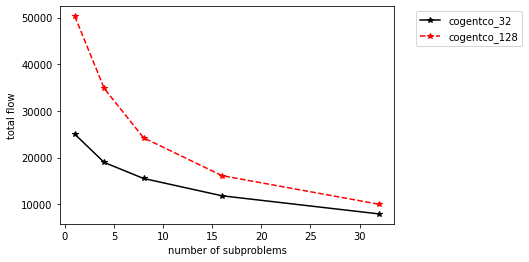

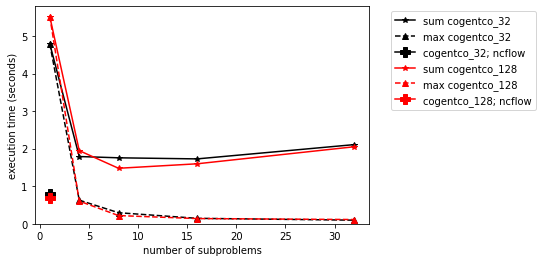

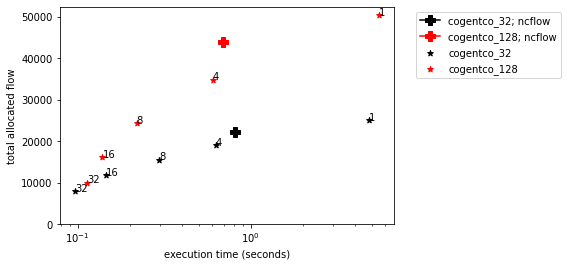

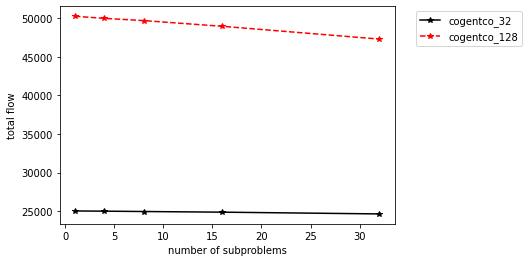

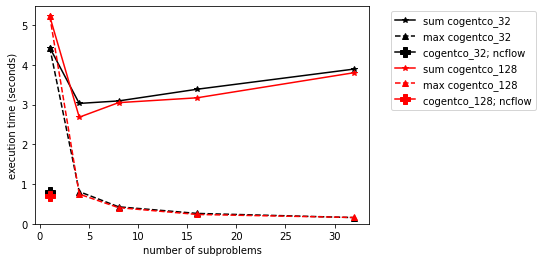

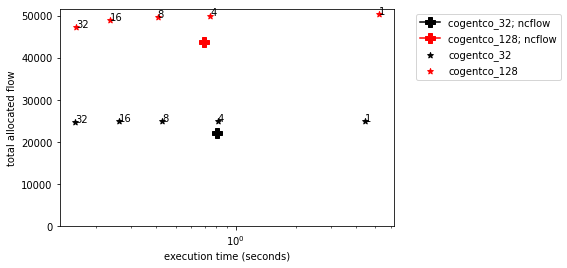

In [9]:
#problems = [p6]
plot_benchmark(results_all_obj, runtimes_all_obj, sol_dicts_all_obj, 
               results_ncflow, runtimes_ncflow)
plot_benchmark(results_all_obj_smart, runtimes_all_obj_smart, 
               sol_dicts_all_obj_smart, results_ncflow, runtimes_ncflow)


In [9]:
problem = Problem.from_file("../topologies/topology-zoo/GtsCe.graphml", 
                            "../traffic-matrices/uniform/GtsCe.graphml_uniform_1475504323_64.0_0.05_traffic-matrix.pkl")
problem.G
#print(problem.G.edges.data())
print(problem.commodity_list[0])
#problem2 = problem.copy()
#print(dir(problem))
"""
problem2.traffic_matrix.tm
new_tm = problem2.traffic_matrix.tm[0:10,:]

num_rows = len(problem2.traffic_matrix.tm)

shuffled_indices = list(range(num_rows))
random.shuffle(shuffled_indices)

num_first_problem = math.floor(num_rows/2)

for i in shuffled_indices[1:num_first_problem]:
    problem2.traffic_matrix.tm[i,:] = 0

#print(problem2.traffic_matrix.tm[1:5,:])

for u,v in problem.G.edges:
    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2
    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2
"""

(0, (0, 1, 0.7263322))


"\nproblem2.traffic_matrix.tm\nnew_tm = problem2.traffic_matrix.tm[0:10,:]\n\nnum_rows = len(problem2.traffic_matrix.tm)\n\nshuffled_indices = list(range(num_rows))\nrandom.shuffle(shuffled_indices)\n\nnum_first_problem = math.floor(num_rows/2)\n\nfor i in shuffled_indices[1:num_first_problem]:\n    problem2.traffic_matrix.tm[i,:] = 0\n\n#print(problem2.traffic_matrix.tm[1:5,:])\n\nfor u,v in problem.G.edges:\n    problem.G[u][v]['capacity'] = problem.G[u][v]['capacity']/2\n    problem2.G[u][v]['capacity'] = problem2.G[u][v]['capacity']/2\n"

In [45]:
validate_solution(sol_dicts_all_obj_smart, num_subproblems)

NameError: name 'assert_flow_conservation' is not defined